# PROJECT-7. Прогнозирование вероятности дефолта клиента по займу на основании кредитной истории. Создание алгоритма определения суммы займа исходя из предсказания модели и анализа цифрового профиля клиента.

# **Задание**

Микрофинансовая организация выдает займы сроком от 16 до 30 дней в размере от 3 до 30 тыс. Решение о сумме выдачи принимается на основе кредитной истории клиента и зависит от вероятности клиента уйти в дефолт. Под дефолтом понимается просрочка первого платежа более чем на 30 дней - FPD30 (first payment default). Так, например, если клиент взял займ сроком на 20 дней, он обязан внести платеж на любую сумму в течение 50 дней, чтобы не уйти в дефолт. Для оценки вероятности дефолта используется модель, обученная на кредитной истории клиента.

**Цель**: сформировать решение по выдаче клиенту микрозайма на основе его кредитной истории.

**Часть 1. Исследовательский анализ:**
1. Провести разведочный анализ данных.
2. Сформировать две выборки:
    - все займы клиентов, исключая последние (**кредитная история**);
    - последние займы клиентов (**обучающая выборка**).
3. Для обучающей выборки сформировать целевую переменную.
4. Сгенерировать и отобрать признаки на **кредитной истории**.

**Часть 2. Обучение и валидация модели:**
1. Обучить модель логистической регрессии и градиентного бустинга на **обучающей выборке**.
По желанию, можно обучить модели с иной архитектурой.
2. Выбрать наилучшую модель и обосновать свое решение.
3. Для выбранной модели провести анализ наиболее информативных признаков.

**Часть 3. Формирование выдачи\*:**
1. Используя предсказания выбранной модели, предложить алгоритм формирования суммы выдачи для клиентов из обучающей выборки. Дополнительно, вместе с предсказанием выбранной модели, можно использовать сгенерированные признаки для формирования суммы выдачи.

**Описание набора данных**:
1. loans.csv - займы клиентов:
    - client_id - идентификатор клиента;
    - loan_id - идентификатор займа;
    - loan_period - период, а который выдавался займ.
    - loan_amount_start - запрашиваемая сумма.
    - loan_amount - выданная сумма.
    - date_issue - дата выдачи займа.
    - date_close - дата закрытия займа.
2. payments.csv - платежи по займам:
    - loan_id - идентификатор займа;
    - pay_type - тип платежа (рекуррентный или не рекуррентный);
    - date_pay - дата платежа;
    - amount - сумма.

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# загрузим данные
df_loans = pd.read_csv('loans.csv')
df_payments = pd.read_csv('payments.csv')

# **Часть 1. Исследовательский анализ**

## 1.1 Провести разведочный анализ данных.

По сути наша конечная цель - это получить признаки поведения клиента (цифровой профиль). Нужно будет выполнить два уровня агрегации. 
**На первом этапе** в виде неких признаков получить информацию из таблицы с платежами для каждого займа(агрегировав по конкретному займу). Тогда таблицы можно будет соединить по ключу loan_id и каждый займ будет содержать характеристики этого займа.  
**На втором этапе** уже нужно агренировать по каждому клиенту, для получения признаков, отображающих информацию по всем займам этого клиента. Это и будет итогом, ведь глобально цель - на основании цифрового профиля клиента сделать прогноз о размере следующего займа.

### Поработаем с таблицей с займами

In [3]:
df_loans

,loan_id,client_id,loan_period,loan_amount_start,loan_amount,date_issue,date_close
0,53229771,54400156,30,30000,28000.0,NaN,NaN
1,49683042,30237545,30,30000,30000.0,2023-02-21,2023-02-28
2,53924354,20194193,30,15000,15000.0,2023-07-18,2023-08-26
3,50358270,46725400,30,30000,30000.0,2023-03-14,2023-03-17
4,52494853,33033499,30,6000,5000.0,2023-05-28,2023-06-02
...,...,...,...,...,...,...,...
700078,52807212,46552326,30,5000,5000.0,2023-06-09,2023-06-09
700079,51321660,21166857,30,30000,21000.0,2023-04-15,2023-06-15
700080,44085364,46044154,16,10000,10000.0,2022-09-05,2022-09-20
700081,41205585,35453411,30,6000,6000.0,NaN,NaN


In [4]:
# Проверим на наличие дубликатов
df_loans.duplicated().sum()

19351

In [5]:
# Удалим дубликаты
df_loans = df_loans.drop_duplicates()

In [6]:
df_loans.info()

<class 'pandas.core.frame.DataFrame'>
Index: 680732 entries, 0 to 700082
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   loan_id            680732 non-null  int64  
 1   client_id          680732 non-null  int64  
 2   loan_period        680732 non-null  int64  
 3   loan_amount_start  680732 non-null  int64  
 4   loan_amount        680732 non-null  float64
 5   date_issue         645759 non-null  object 
 6   date_close         617564 non-null  object 
dtypes: float64(1), int64(4), object(2)
memory usage: 41.5+ MB


In [7]:
#признаки, содержащие дату приведем к формату Datetime
df_loans['date_issue'] = pd.to_datetime(df_loans['date_issue'])
df_loans['date_close'] = pd.to_datetime(df_loans['date_close'])

In [8]:
# выведем основные статистические характеристики
df_loans.describe()

,loan_id,client_id,loan_period,loan_amount_start,loan_amount,date_issue,date_close
count,6.807320e+05,6.807320e+05,680732.000000,680732.000000,680732.000000,645759,617564
mean,4.910902e+07,3.938367e+07,25.900539,14900.176575,10974.514199,2023-02-10 17:13:56.676840960,2023-03-06 06:15:11.757810688
min,3.566015e+07,1.849973e+07,16.000000,3000.000000,0.000000,2022-01-01 00:00:00,2022-01-01 00:00:00
25%,4.586048e+07,2.933602e+07,20.000000,5000.000000,4000.000000,2022-11-01 00:00:00,2022-11-30 00:00:00
50%,5.105932e+07,4.197092e+07,30.000000,10000.000000,9000.000000,2023-04-06 00:00:00,2023-04-26 00:00:00
75%,5.328710e+07,4.969350e+07,30.000000,30000.000000,15000.000000,2023-06-26 00:00:00,2023-07-07 00:00:00
max,5.438614e+07,5.549596e+07,46.000000,30000.000000,35000.000000,2023-07-31 00:00:00,2023-12-31 00:00:00
std,5.058991e+06,1.144697e+07,6.109531,10655.063212,8250.778730,NaN,NaN


Видим, что по условиям задачи максимальный срок кредита 30 дней, а мы наблюдаем максимальный период 46. Займы, выдаваемые на период менее 16 и более 30 дней в рамках задачи будем считать выбросами.(займов сроком меньше 16 дней как видим нет)  
Кроме того, в задаче четко обозначена сумма займа. Займы вне этой суммы рассмаривать не будем.   
Также видим, что бывают случаи, когда выданная сумма оказывается больше запрашиваемой, хотя такой ситуации быть не должно. Такие случаи также будем считать выбросами. 

In [9]:
# Оставим записи, удовлетворяющие сроку займа
df_loans = df_loans[df_loans['loan_period'] <= 30]
# Оставим записи, удовлетворяющие размеру займа
df_loans = df_loans[df_loans['loan_amount'] >= 3000]
df_loans = df_loans[df_loans['loan_amount'] <= 30000]

In [10]:
# Проверим, сколько строк, когда сумма выданного кредита больше запрашивоемого
df_loans[df_loans['loan_amount'] > df_loans['loan_amount_start']]

,loan_id,client_id,loan_period,loan_amount_start,loan_amount,date_issue,date_close


Таких данных не осталось.

In [11]:
# Проверим на пропуски
df_loans.isna().sum()

loan_id                  0
client_id                0
loan_period              0
loan_amount_start        0
loan_amount              0
date_issue           33180
date_close           61375
dtype: int64

Есть строки, где не указана дата выдачи займа. Это ключевой параметр, без него информация не имеет смысла. Удалим такие строки.

In [12]:
df_loans = df_loans[~df_loans['date_issue'].isna()]

In [13]:
print(f"Количество уникалиных клиентов: {df_loans['client_id'].nunique()}")
print(f"Количество уникалиных значений долга: {df_loans['loan_id'].nunique()}")
print(f"Количество строк в датасете: {df_loans.shape[0]}")

Количество уникалиных клиентов: 111170
Количество уникалиных значений долга: 643965
Количество строк в датасете: 643965


Отлично, датасет с займами очищен от пропусков, выбросов и содержит только уникальные id займов.

### Поработаем с таблицей с платежами

In [14]:
df_payments

,loan_id,pay_type,date_pay,amount
0,53889483,not_rec,2023-09-14 12:39:22,6000.0
1,54056114,not_rec,2023-08-11 00:00:02,500.0
2,54056114,not_rec,2023-09-14 00:00:02,10.0
3,53434011,not_rec,2023-09-25 10:41:13,2620.0
4,53691733,not_rec,2023-09-25 07:38:04,3628.0
...,...,...,...,...
1070079,52520569,not_rec,2023-06-01 22:00:13,NaN
1070080,53123669,not_rec,2023-06-23 14:37:43,NaN
1070081,50376529,not_rec,2023-04-06 21:41:05,NaN
1070082,46628813,not_rec,2022-12-15 00:00:02,NaN


In [15]:
df_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070084 entries, 0 to 1070083
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   loan_id   1070084 non-null  int64  
 1   pay_type  1070084 non-null  object 
 2   date_pay  1070084 non-null  object 
 3   amount    1064810 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 32.7+ MB


In [16]:
# Проверим на дубликаты
df_payments.duplicated().sum()

48803

In [17]:
# Удалим дубликаты
df_payments = df_payments.drop_duplicates()

In [18]:
#признаки, содержащие дату приведем к формату Datetime
df_payments['date_pay'] =  pd.to_datetime(df_payments['date_pay'])

In [19]:
df_payments['loan_id'].nunique()

635305

В этой таблице есть информация по займам, которых нет в таблице по займам. Учтем это при объединении таблиц.

## Объединим таблицы

Перед объединением вторую таблицу нужно сагрегировать по loai_id, т.к. в df_loan у нас уникальные значения loan_id. Набор агренатных функций сделаем стразу, чтоб потом из них получить новые признаки. Т.е. выполняем агрегацию таблицы **df_payments**

In [20]:

payment_features = df_payments.groupby('loan_id').agg({
    'amount': ['sum', 'count', 'mean'], # сумма, кол-во и средний платеж по займу
    'date_pay': ['min', 'max', 'nunique'], # первый и последний платеж по займу, кол0во уник. займов
    'pay_type': lambda x: (x == 'rec').sum() # кол-во реккурентных платежей
}).reset_index()

# Названия колонок сделаем более понятными
payment_features.columns = [
    'loan_id', 'total_paid', 'payment_count', 'avg_payment', 
    'first_payment_date', 'last_payment_date', 'unique_payment_days', 
    'recurring_payments_count'
]

In [21]:
# Объединяем loans и payments
df_merged = df_loans.merge(payment_features, on='loan_id', how='left')

# Проверим результат
print(f"Размер объединенной таблицы: {df_merged.shape}")

Размер объединенной таблицы: (643965, 14)


In [22]:
df_merged.head(4)

,loan_id,client_id,loan_period,loan_amount_start,loan_amount,date_issue,date_close,total_paid,payment_count,avg_payment,first_payment_date,last_payment_date,unique_payment_days,recurring_payments_count
0,49683042,30237545,30,30000,30000.0,2023-02-21,2023-02-28,30306.0,3.0,10102.0,2023-02-22 00:00:02,2023-02-28 00:00:02,3.0,0.0
1,53924354,20194193,30,15000,15000.0,2023-07-18,2023-08-26,22024.8,2.0,11012.4,2023-08-26 00:29:03,2023-08-26 18:49:43,2.0,1.0
2,50358270,46725400,30,30000,30000.0,2023-03-14,2023-03-17,30900.0,1.0,30900.0,2023-03-17 00:00:02,2023-03-17 00:00:02,1.0,0.0
3,52494853,33033499,30,6000,5000.0,2023-05-28,2023-06-02,5250.0,1.0,5250.0,2023-06-02 18:54:05,2023-06-02 18:54:05,1.0,0.0


Все четко, все уникальные займы остались, лишнего не добавилось.

## 1.3 Создаем целевую переменную 
( выполним этот шаг чуть раньше, создадим для всего даатфейма, потом отдельно выделим обучающую выборку)

Тут один важный момент, можно отнести займ к дефолтному если дата первого платежа минус дата выдачи займа превышает срок выдачи кредита + 30 дней, но бывают новые займы, по которым еще не наступил срок платежа, и важно не отнести их к дефолтным по умолчанию.

In [23]:
# Нам нужно определить дату анализа - то есть на какой день мы будем оценивать просрочен или нет новый займ. Вовзьмем ее как максимальную из тех, что есть
analysis_date = max(df_merged['date_close'].max(), df_merged['last_payment_date'].max())
print(f"Дата анализа: {analysis_date}")

# Время ммежду первым платежом и датой займа
df_merged['first_payment_delay'] = (df_merged['first_payment_date'] - df_merged['date_issue']).dt.days

# Вычисляем крайний срок для платежа (дата выдачи + срок займа + 30 дней)
df_merged['payment_deadline'] = df_merged['date_issue'] + pd.to_timedelta(df_merged['loan_period'] + 30, unit='d')

# Определяем дефолт по правилам:
df_merged['default'] = 0  # по умолчанию не дефолт

# Случай 1: Есть платежи, но первый платеж опоздал
has_payments = df_merged['first_payment_date'].notna()
late_payment = df_merged['first_payment_delay'] > df_merged['loan_period'] + 30
df_merged.loc[has_payments & late_payment, 'default'] = 1

# Случай 2: Нет платежей И срок платежа уже прошел на дату анализа
no_payments = df_merged['first_payment_date'].isna()
deadline_passed = df_merged['payment_deadline'] < analysis_date
df_merged.loc[no_payments & deadline_passed, 'default'] = 1

# Случай 3: Нет платежей, но срок еще не прошел - оставляем как 0 (не дефолт)

print("Распределение целевой переменной:")
print(df_merged['default'].value_counts())
print(f"Доля дефолтов: {df_merged['default'].mean():.2%}")


Дата анализа: 2023-12-31 22:17:55
Распределение целевой переменной:
default
0    609307
1     34658
Name: count, dtype: int64
Доля дефолтов: 5.38%


In [24]:
# Проверим займы без платежей
no_payment_loans = df_merged[df_merged['first_payment_date'].isna()]
print(f"\nЗаймов без платежей: {len(no_payment_loans)}")
print(f"Из них дефолтных (срок прошел): {no_payment_loans['default'].sum()}")
print(f"Из них не дефолтных (срок еще не прошел): {len(no_payment_loans) - no_payment_loans['default'].sum()}")


Займов без платежей: 14661
Из них дефолтных (срок прошел): 14661
Из них не дефолтных (срок еще не прошел): 0


В принципе как видим для этих данных все займы без платежей относятся к дефолтным, но проверить стоило.

###  Создаем новые признаки в объединенной таблице

In [25]:
# Заполняем пропуски для займов без платежей
payment_cols = ['total_paid', 'payment_count', 'avg_payment', 'unique_payment_days', 'recurring_payments_count']
df_merged[payment_cols] = df_merged[payment_cols].fillna(0)

# Создаем полезные производные признаки

# Сколько в днях длился займ
df_merged['loan_time'] = np.where(
    df_merged['date_close'].notna(),
    (df_merged['date_close'] - df_merged['date_issue']).dt.days,
    np.nan)

# Доля погашения займа
df_merged['paid_ratio'] = df_merged['total_paid'] / df_merged['loan_amount']
df_merged['paid_ratio'] = df_merged['paid_ratio'].fillna(0)

# Доля рекуррентных платежей
df_merged['pay_type_ratio'] = np.where(
    df_merged['payment_count'] > 0,
    df_merged['recurring_payments_count'] / df_merged['payment_count'],
    0
)

# Количество дней между первым платежом и датой займа
df_merged['days_to_first_payment'] = (df_merged['first_payment_date'] - df_merged['date_issue']).dt.days
df_merged['days_to_first_payment'] = df_merged['days_to_first_payment'].fillna(-1)  # -1 для займов без платежей

# Период платежей (в днях)
df_merged['payment_period_days'] = (df_merged['last_payment_date'] - df_merged['first_payment_date']).dt.days
df_merged['payment_period_days'] = df_merged['payment_period_days'].fillna(0)  # 0 для займов без платежей или с одним платежом

## 1.2 Разделяем на кредитную историю и обучающую выборку

In [26]:
# Сортируем по клиентам и дате выдачи
df_sorted = df_merged.sort_values(['client_id', 'date_issue'])

# Находим последний займ для каждого клиента (тут будут и новые клиенты, у которых всего один займ взят)
last_loans_indices = df_sorted.groupby('client_id').tail(1).index

# Кредитная история это все займы кроме последних
credit_history = df_sorted[~df_sorted.index.isin(last_loans_indices)]

# Ну и обучающая выборка = последние займы старых + новые клиенты
train_data = df_sorted[df_sorted.index.isin(last_loans_indices)]

print(f"Кредитная история: {len(credit_history)} займов")
print(f"Обучающая выборка: {len(train_data)} займов")
print(f"Исходная таблица: {len(df_merged)} займов")



Кредитная история: 532795 займов
Обучающая выборка: 111170 займов
Исходная таблица: 643965 займов


In [27]:
print(f"Кредитная история: {credit_history['client_id'].nunique()} клиентов")
print(f"Обучающая выборка: {train_data['client_id'].nunique()} клиентов")

Кредитная история: 111031 клиентов
Обучающая выборка: 111170 клиентов


In [28]:
credit_history.head(1)

,loan_id,client_id,loan_period,loan_amount_start,loan_amount,date_issue,date_close,total_paid,payment_count,avg_payment,...,unique_payment_days,recurring_payments_count,first_payment_delay,payment_deadline,default,loan_time,paid_ratio,pay_type_ratio,days_to_first_payment,payment_period_days
48396,52593332,18499732,30,5000,5000.0,2023-06-01,2023-06-11,5500.0,1.0,5500.0,...,1.0,0.0,10.0,2023-07-31,0,10.0,1.1,0.0,10.0,0.0


In [29]:
credit_history.info()

<class 'pandas.core.frame.DataFrame'>
Index: 532795 entries, 48396 to 288532
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   loan_id                   532795 non-null  int64         
 1   client_id                 532795 non-null  int64         
 2   loan_period               532795 non-null  int64         
 3   loan_amount_start         532795 non-null  int64         
 4   loan_amount               532795 non-null  float64       
 5   date_issue                532795 non-null  datetime64[ns]
 6   date_close                532603 non-null  datetime64[ns]
 7   total_paid                532795 non-null  float64       
 8   payment_count             532795 non-null  float64       
 9   avg_payment               532795 non-null  float64       
 10  first_payment_date        532670 non-null  datetime64[ns]
 11  last_payment_date         532670 non-null  datetime64[ns]
 12  uni


## 1.4 Cоздаем признаки клиента из кредитной истории
Вот тут уже агрегируем по клиенту, это второй уровень агренации наших данных.

In [30]:
credit_history.head(1)

,loan_id,client_id,loan_period,loan_amount_start,loan_amount,date_issue,date_close,total_paid,payment_count,avg_payment,...,unique_payment_days,recurring_payments_count,first_payment_delay,payment_deadline,default,loan_time,paid_ratio,pay_type_ratio,days_to_first_payment,payment_period_days
48396,52593332,18499732,30,5000,5000.0,2023-06-01,2023-06-11,5500.0,1.0,5500.0,...,1.0,0.0,10.0,2023-07-31,0,10.0,1.1,0.0,10.0,0.0


In [31]:
client_features = credit_history.groupby('client_id').agg({
    # Базовые признаки
    'loan_id': 'count', # количество займов
    'loan_amount': ['mean', 'max', 'sum'], # среднее, макс и общая сумма займов
    'loan_period': 'mean', # средний период займов
    'default': 'mean', # среднее количество дефолтов
    # Признаки из платежей (базовые)
    'total_paid': 'sum', # cуммарно сколько выплатил по займам
    'payment_count': 'mean', # в среднем платежей по займам
    'unique_payment_days': 'mean', # среднее количество уникальных дней с платежами
    # Признаки, созданные дополнительно
    'paid_ratio': 'mean', # средняя доля погашения по займам
    'pay_type_ratio': 'mean', # средняя доля рекуррентных платежей
    'days_to_first_payment': ['mean','max'], # среднее и макс. количество дней до первого платежа
    'payment_period_days': 'mean'  # средняя продолжительность периода платежей
}).reset_index()

In [32]:
# Переименовываем столбцы после агрегации
client_features.columns = [
    'client_id',                           # идентификатор клиента
    'prev_loans_count',                   # количество предыдущих займов
    'avg_loan_amount',                    # средняя сумма займов
    'max_loan_amount',                    # максимальная сумма займа
    'total_loan_amount',                  # общая сумма всех займов
    'avg_loan_period',                    # средний период займа
    'default_rate_history',               # доля дефолтов в истории
    'total_paid_all_loans',               # общая сумма выплат по всем займам
    'avg_payment_count',                  # среднее количество платежей по займам
    'avg_unique_payment_days',            # среднее количество уникальных дней с платежами
    'avg_paid_ratio',                     # средняя доля погашения займов
    'avg_pay_type_ratio',                 # средняя доля рекуррентных платежей
    'avg_days_to_first_payment',          # среднее количество дней до первого платежа
    'max_days_to_first_payment',          # максимальное количество дней до первого платежа
    'avg_payment_period_days'             # средняя продолжительность периода платежей
]

In [33]:
# Для loan_time используем только закрытые займы в кредитной истории
closed_loans_history = credit_history[credit_history['loan_time'].notna()]
loan_time_features = closed_loans_history.groupby('client_id').agg({
    'loan_time': ['mean','max'] # средняя и макс прололжительность займа
}).reset_index()

loan_time_features.columns = ['client_id', 'avg_loan_time', 'max_loan_time']

In [34]:
# Объединяем все признаки клиента

all_client_features = client_features.merge(loan_time_features, on='client_id', how='left')

# Для незакрытых займов заменим значения про продолжительности займа на -1. Будем понимать, что у клиента нет зактытых займов в кредитнйо истории
all_client_features['avg_loan_time'] = all_client_features['avg_loan_time'].fillna(-10) 
all_client_features['max_loan_time'] = all_client_features['max_loan_time'].fillna(-10)  

In [35]:
all_client_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111031 entries, 0 to 111030
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   client_id                  111031 non-null  int64  
 1   prev_loans_count           111031 non-null  int64  
 2   avg_loan_amount            111031 non-null  float64
 3   max_loan_amount            111031 non-null  float64
 4   total_loan_amount          111031 non-null  float64
 5   avg_loan_period            111031 non-null  float64
 6   default_rate_history       111031 non-null  float64
 7   total_paid_all_loans       111031 non-null  float64
 8   avg_payment_count          111031 non-null  float64
 9   avg_unique_payment_days    111031 non-null  float64
 10  avg_paid_ratio             111031 non-null  float64
 11  avg_pay_type_ratio         111031 non-null  float64
 12  avg_days_to_first_payment  111031 non-null  float64
 13  max_days_to_first_payment  11

## Проверим корреляцию между признаками и целевой переменной.

In [36]:
# Объединим признаки с целевой переменной из обучающей выборки
analysis_df = train_data[['client_id', 'default']].merge(
    all_client_features, on='client_id', how='left'
)

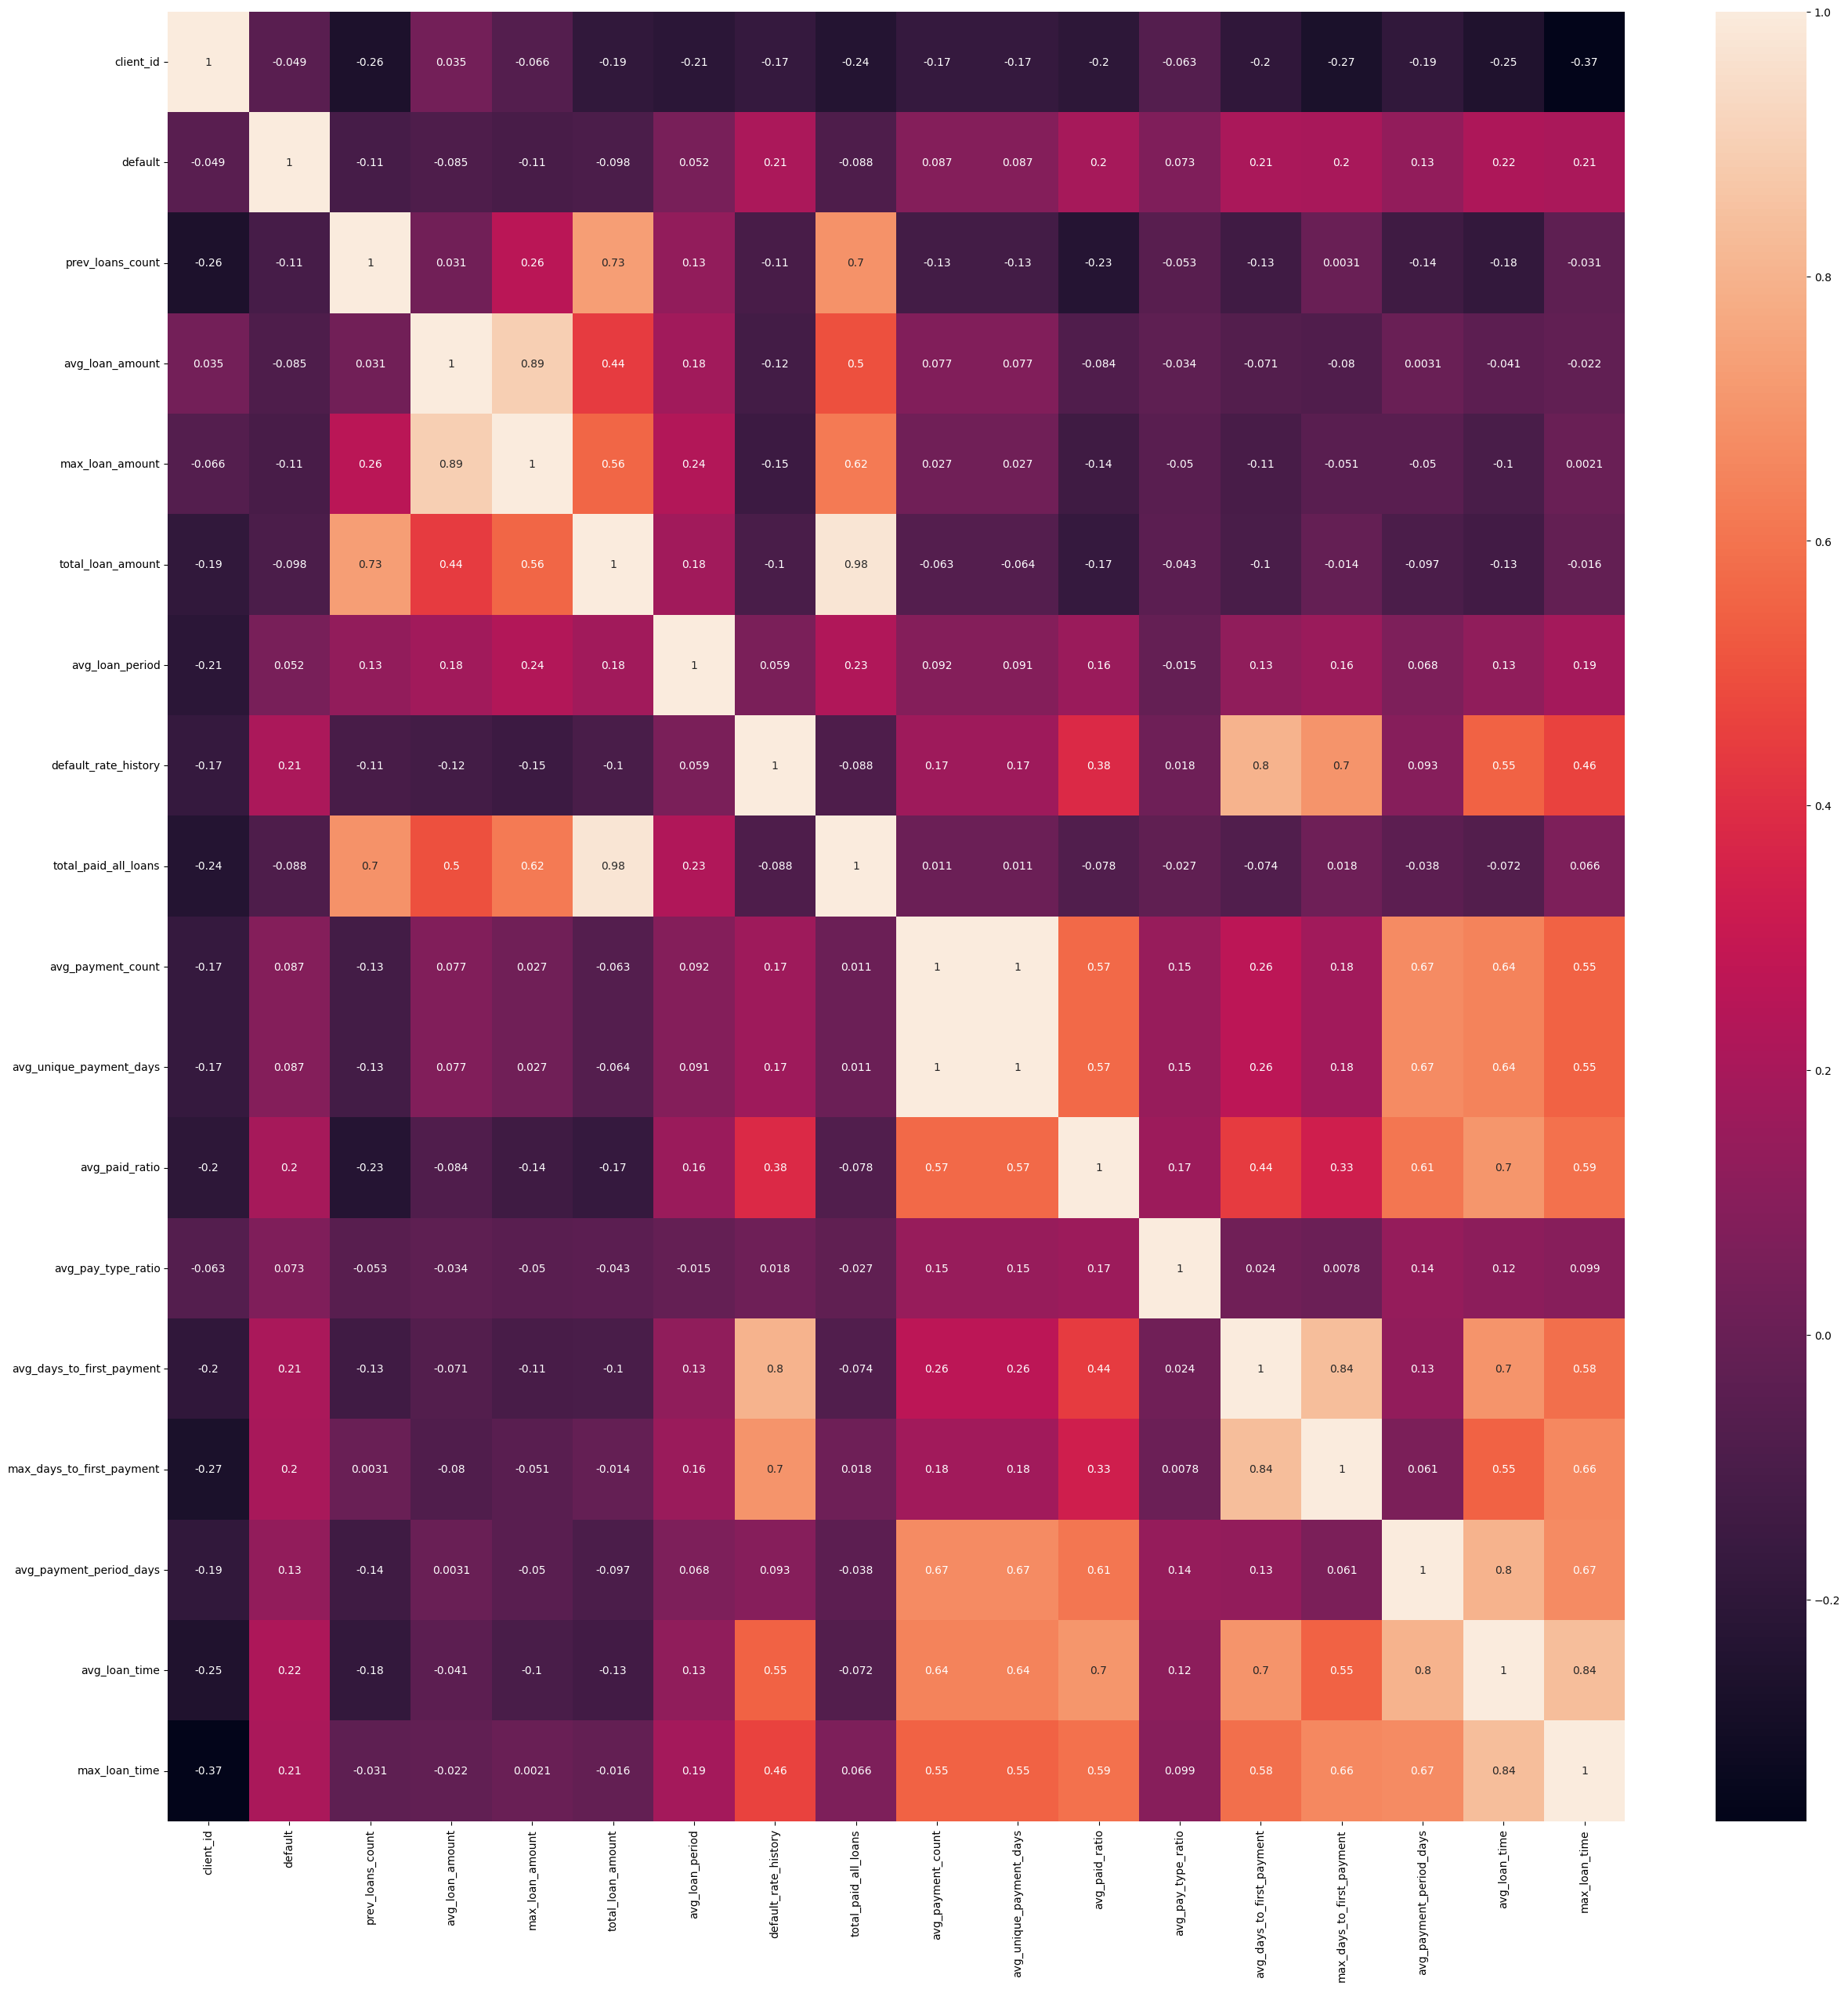

In [37]:
plt.figure(figsize = (30, 30))
sns.heatmap(analysis_df.corr(numeric_only=True), annot = True);

С целевой переменной у признаков сильной корреляции нет, а вот у некоторых признаков корреляция высокая (будем считать высокой более 0.8),т.е. признаки сообщают модели одну и туже информацию. Удалим их.

In [38]:
all_client_features = all_client_features.drop(columns=['max_days_to_first_payment','avg_unique_payment_days','total_paid_all_loans','max_loan_amount','avg_loan_time'], axis=1)

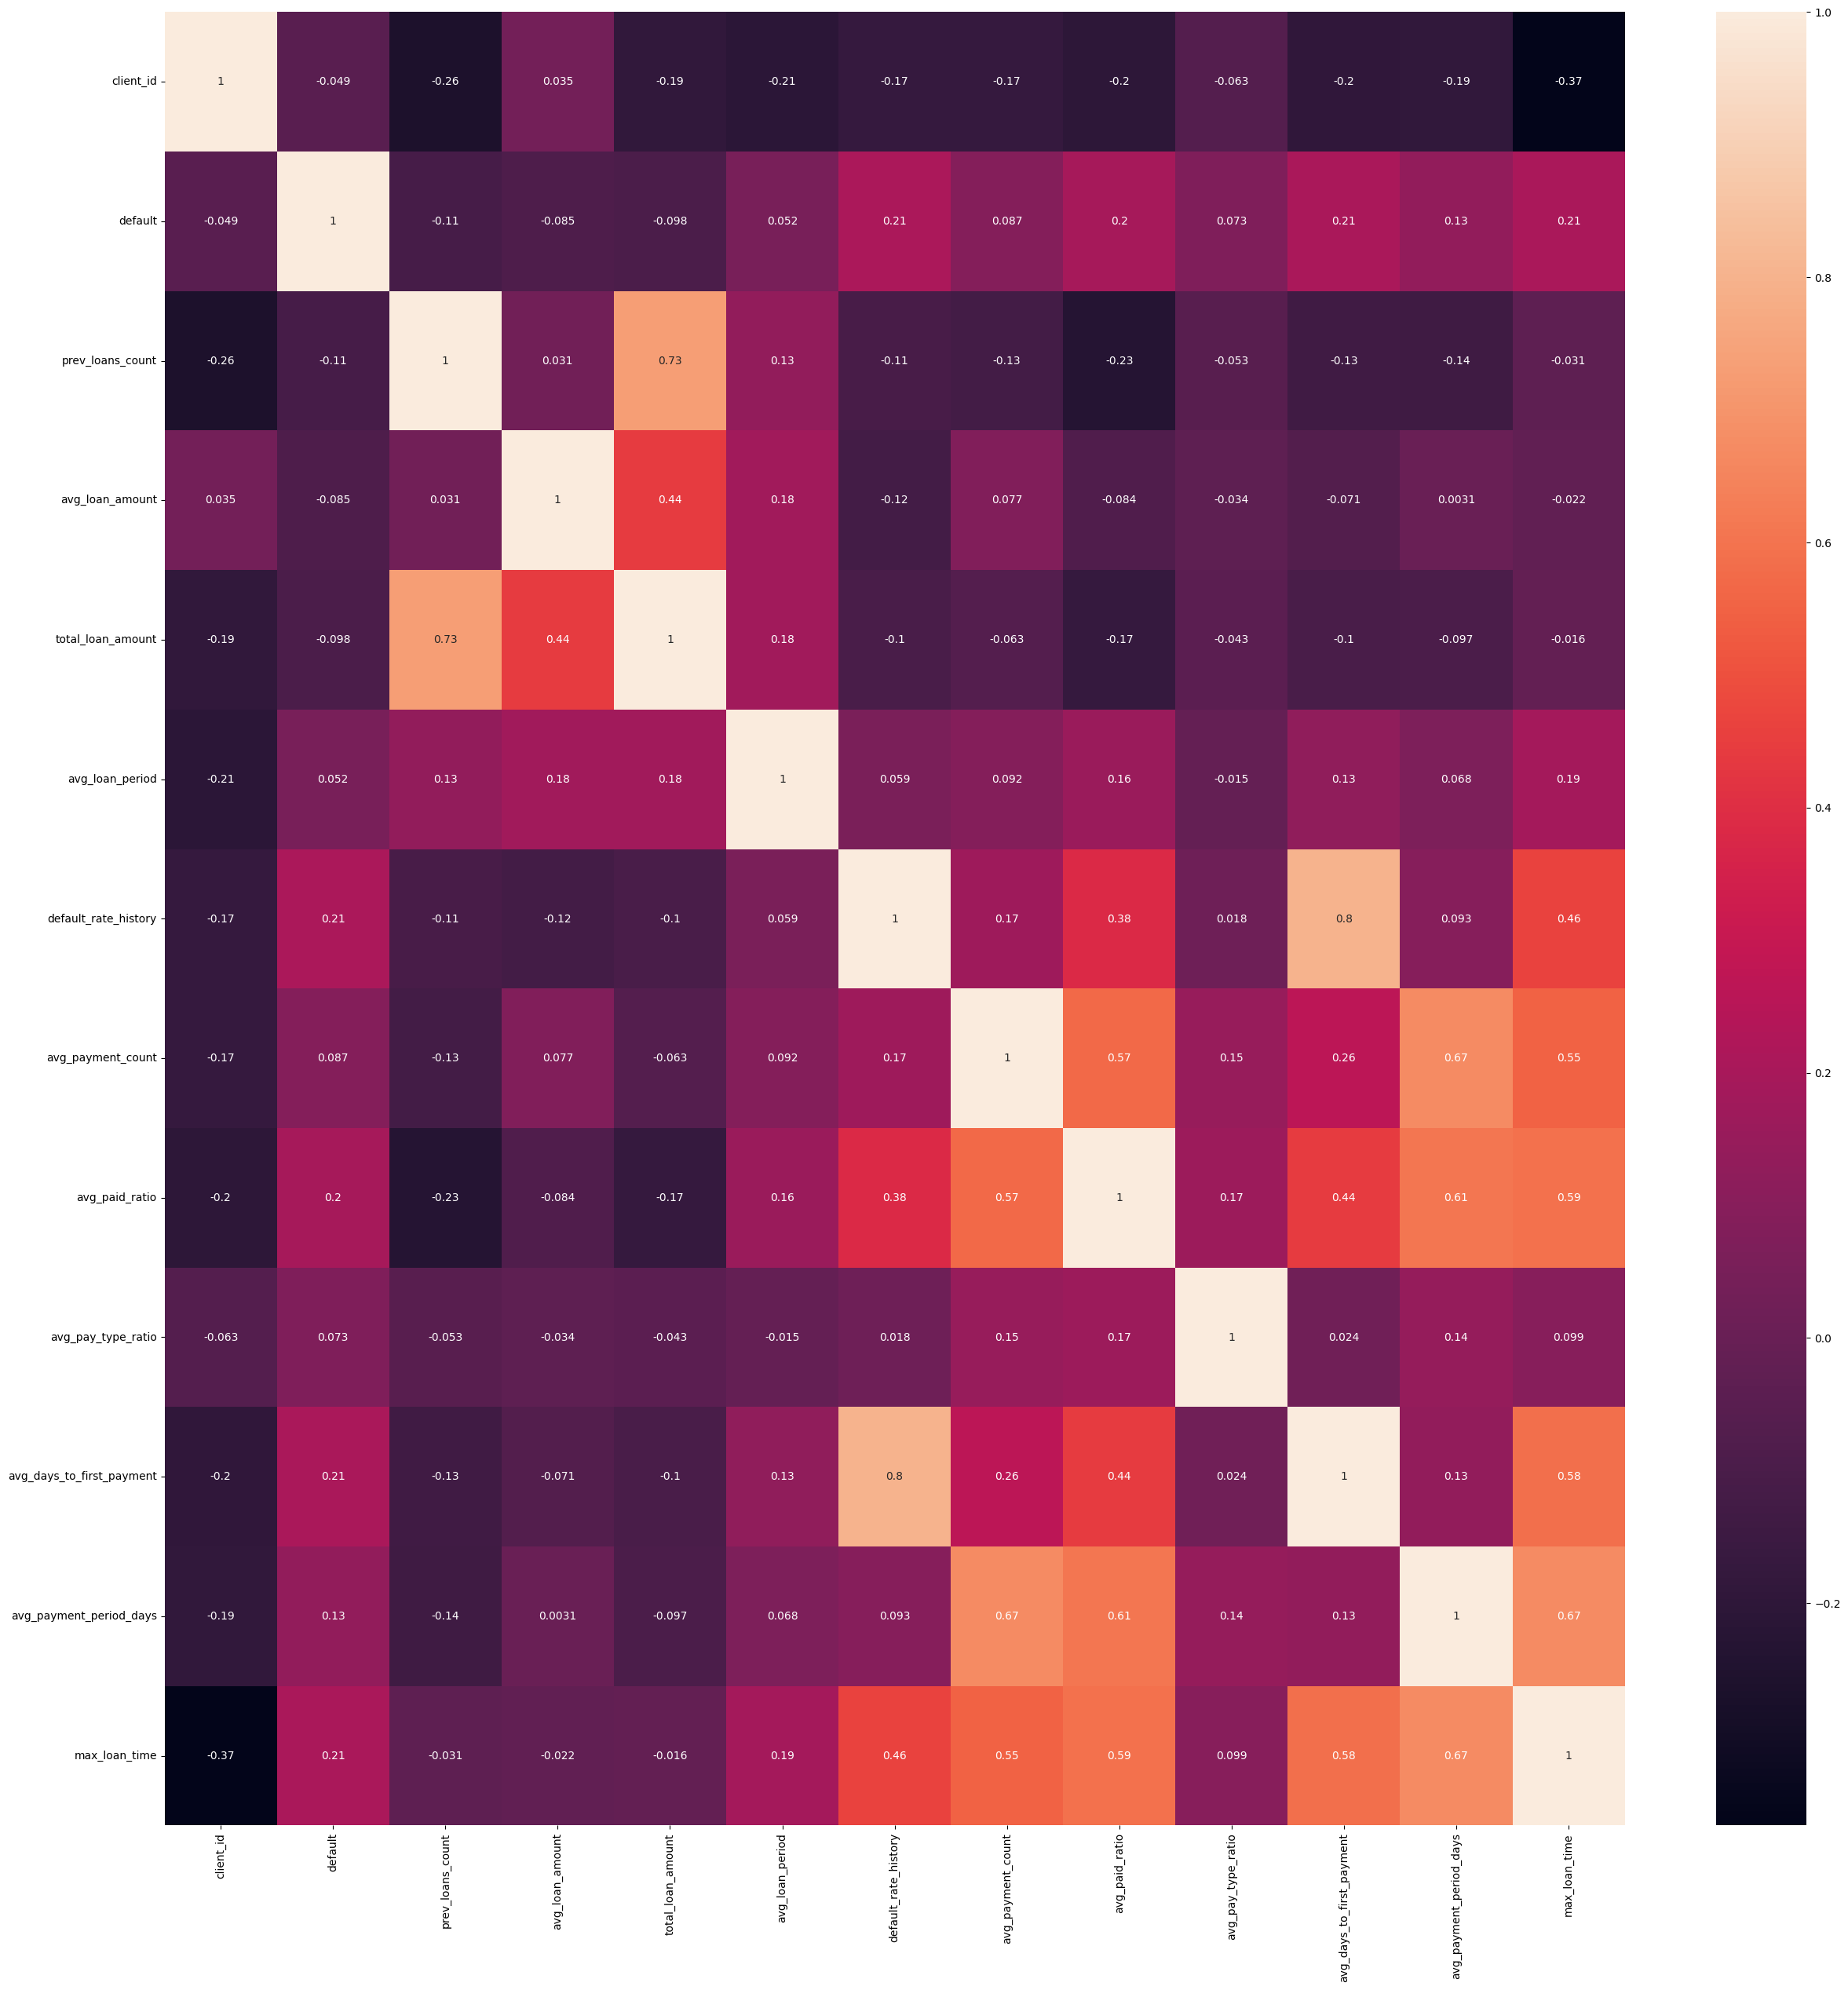

In [39]:
# Повторим процедуру
analysis_df = train_data[['client_id', 'default']].merge(
    all_client_features, on='client_id', how='left'
)
plt.figure(figsize = (30, 30))
sns.heatmap(analysis_df.corr(numeric_only=True), annot = True);

Отлично, признаки на кредитной истории отобраны.

## Создадим выборку для обучения

Сначала создадим выборку для обучения. Будем использовать обучающую выборку (последние займы клиентов) и дополним ее цифровым профилем из кредитной истории. При этом уберем новых клиентов без кредитной истории, по условиям задачи они не нужны.

In [40]:
# тут объединяем по inner, т.к. в таблице all_client_features у нас только клиенты с историей и клинты без истории из train_data не попадут
model_data = train_data[['client_id', 'loan_id', 'default']].merge(
    all_client_features, on='client_id', how='inner'
)
# Добавляем ключевые признаки из текущего займа (которые известны до выдачи)
model_data = model_data.merge(
    train_data[['loan_id', 'loan_amount_start', 'loan_amount', 'loan_period']],
    on='loan_id', how='left'
)
# Теперь признак loan_id нам не нужен, удалим его
model_data = model_data.drop(columns='loan_id',axis=1)

print(f"Финальный размер данных для модели: {model_data.shape}")
print(f"Количество клиентов с кредитной историей: {model_data['client_id'].nunique()}")
print(f"Доля дефолтов в финальной выборке: {model_data['default'].mean():.2%}")

Финальный размер данных для модели: (111031, 16)
Количество клиентов с кредитной историей: 111031
Доля дефолтов в финальной выборке: 18.34%


In [41]:
# еще раз провери на отсутствие пропусков
model_data.isna().sum()

client_id                    0
default                      0
prev_loans_count             0
avg_loan_amount              0
total_loan_amount            0
avg_loan_period              0
default_rate_history         0
avg_payment_count            0
avg_paid_ratio               0
avg_pay_type_ratio           0
avg_days_to_first_payment    0
avg_payment_period_days      0
max_loan_time                0
loan_amount_start            0
loan_amount                  0
loan_period                  0
dtype: int64

**Итоговые признаки:**  
    - ****client_id** **- идентификатор клиента  
    - **default** - целевая переменная  
    - **prev_loans_count** - количество предыдущих займов  
    - **avg_loan_amount** -средняя сумма займов  
    -  **total_loan_amount** - общая сумма всех займов  
    - **avg_loan_period** - средний период займа  
    - **default_rate_history** - доля дефолтов в истории  
    - **avg_payment_count** - среднее количество платежей по займам  
    - **avg_paid_ratio** - средняя доля погашения займов  
    - **avg_pay_type_ratio** - средняя доля рекуррентных платежей    
    - **avg_days_to_first_payment** - среднее количество дней до первого платежа    
    - **avg_payment_period_days** - средняя продолжительность периода платежей   
    - **max_loan_time** - максимальное время займа  
    - **loan_amount_start** - запрашиваемая сумма  
    - **loan_amount** - выданная сумма  
    - **loan_period** - период, а который выдавался займ  
      

Теперь посмотрим на распределение признаков, наличие выбросов. Построим два графика, гисторграмму распределения и короьчатую диаграмму в зависимости от целевой переменной.

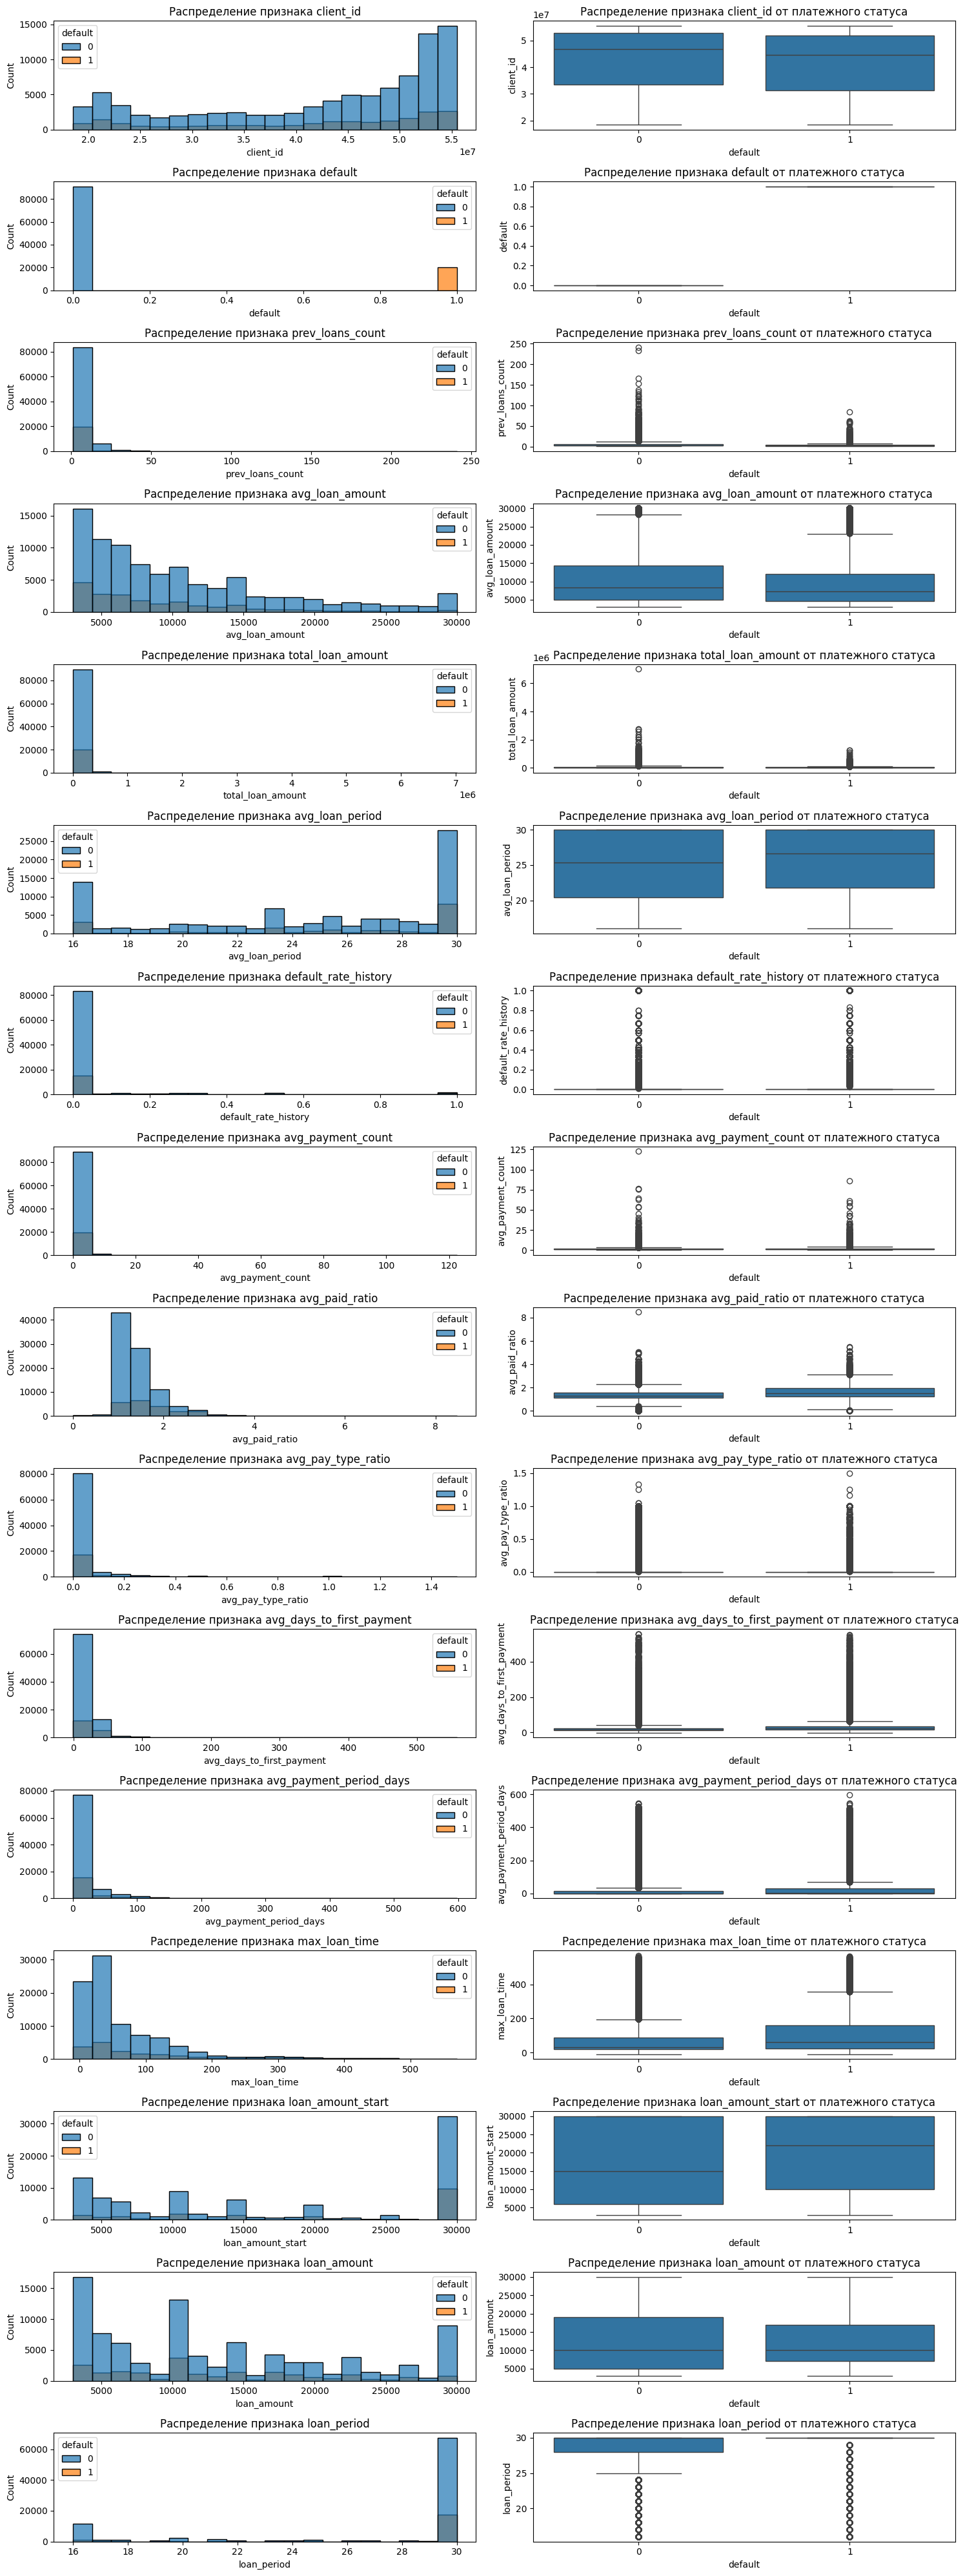

In [42]:
features = model_data.columns.tolist()

n = len(features) #число  признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) #фигура+n*2 координатных плоскостей
#Создаем цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(features):
    #Строим гисторгамму распределения признака
    histplot = sns.histplot(data=model_data, x=feature, hue='default', ax=axes[i][0], alpha=0.7, bins=20, kde=False)
    histplot.set_title(f'Распределение признака {feature}')
    #Строим коробчатую диаграмму
    boxplot = sns.boxplot(data=model_data, x='default', y=feature, ax=axes[i][1])
    boxplot.set_title(f'Распределение признака {feature} от платежного статуса')
    plt.tight_layout() #выравнивание графиков

Вообще выглядит страшно. По ряду признаков очень много выбросов, они имеют четко выраженую правостороннюю асимметрию распределения. Основное распределение данных сконцентрировано в небольшой области, а дальше имеем длинный хвост значений. Забегая вперед я обучил модели на различных вариантах ( код для всех тут писать не буду, напишу результат):
- оставил как есть
- убрал выбросы по методу Тьюки(пробовал разные коэффициенты умножения на межквартильный размах)
- пробовал по методу z-отклонений (но данные не распределены нормально, поэтому не очень эффективно)
- задал верние и нижние границы как lower_bound = Q1 - (1.5 * IQR) и upper_bound = Q3 + (1.5 * IQR) и все что ниже/выше этих значений заменил на эти значения
- доработал предыдущий способ и внес какую-то логику.

В общем если выучить модель на признаках как есть сейчас, получаем наилучшие метрики. Любое ограничение выборки путем удаления выбросов делает модель хуже. Видимо в критические значения параметров попадают дефолты, а мы их удаляем и делаем беднее и без того маленькую долю миноритарного класса, что важно для модели (а это не выбросы, а особые случаи кредитного поведения)

Последний способ позволяет добиться примерно таких же результатов. Попробуем его тоже и сравним с первоначальным результатом. 

Создадим список признаков, значения с отклонениями выше границ будем заменять. Это тоже не совмес правильно, потому что создаем на границе искусственное увеличение этого признака, но как показывает практика лучше чем удалять (похоже на деление на значимые категории + прочее, где сумма всех мелких категорий). Тут не все признаки, например default_rate_history и loan_period трогать нельзя, заменим важные занчения.   

In [43]:
features_to_clean = features_to_clean = ['prev_loans_count',
       'avg_loan_amount', 'total_loan_amount', 'avg_loan_period', 'avg_payment_count', 'avg_paid_ratio',
       'avg_days_to_first_payment',
       'avg_payment_period_days', 'max_loan_time', 'loan_amount_start',
       'loan_amount']

In [44]:
def cap_outliers(data, features, left=1.5, right=1.8):
    """Ограничивает выбросы вместо удаления строк"""
    data_capped = data.copy()
    
    for feature in features:
        x = data[feature]
        Q1 = x.quantile(0.25)
        Q3 = x.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - (left * IQR)
        upper_bound = Q3 + (right * IQR)
        
        # Ограничиваем выбросы
        data_capped[feature] = x.clip(lower=lower_bound, upper=upper_bound)
        
        # Статистика по ограничению
        capped_lower = (x < lower_bound).sum()
        capped_upper = (x > upper_bound).sum()
        print(f"{feature}: ограничено {capped_lower} снизу {lower_bound:.2f}, {capped_upper} сверху {upper_bound:.2f}")
    
    return data_capped

# Применяем ограничение
capped_data = cap_outliers(model_data, features_to_clean)
print(f"Длина выборки {len(capped_data)} записей")

prev_loans_count: ограничено 0 снизу -6.50, 4845 сверху 15.00
avg_loan_amount: ограничено 0 снизу -8500.00, 0 сверху 30200.00
total_loan_amount: ограничено 0 снизу -61500.00, 7174 сверху 149200.00
avg_loan_period: ограничено 0 снизу 6.67, 0 сверху 46.80
avg_payment_count: ограничено 0 снизу -0.50, 9465 сверху 3.80
avg_paid_ratio: ограничено 231 снизу 0.35, 3308 сверху 2.63
avg_days_to_first_payment: ограничено 0 снизу -9.55, 6685 сверху 50.60
avg_payment_period_days: ограничено 0 снизу -22.75, 13794 сверху 42.47
max_loan_time: ограничено 0 снизу -102.50, 7409 сверху 245.80
loan_amount_start: ограничено 0 снизу -27500.00, 0 сверху 71400.00
loan_amount: ограничено 0 снизу -16000.00, 0 сверху 44200.00
Длина выборки 111031 записей


In [45]:
# Ограничим только avg_pay_type_ratio, т.к. число рекуррентых платежей не может быть больше числа платежей вообще
capped_data = capped_data[capped_data['avg_pay_type_ratio'] <= 1]
capped_data.shape

(111023, 16)

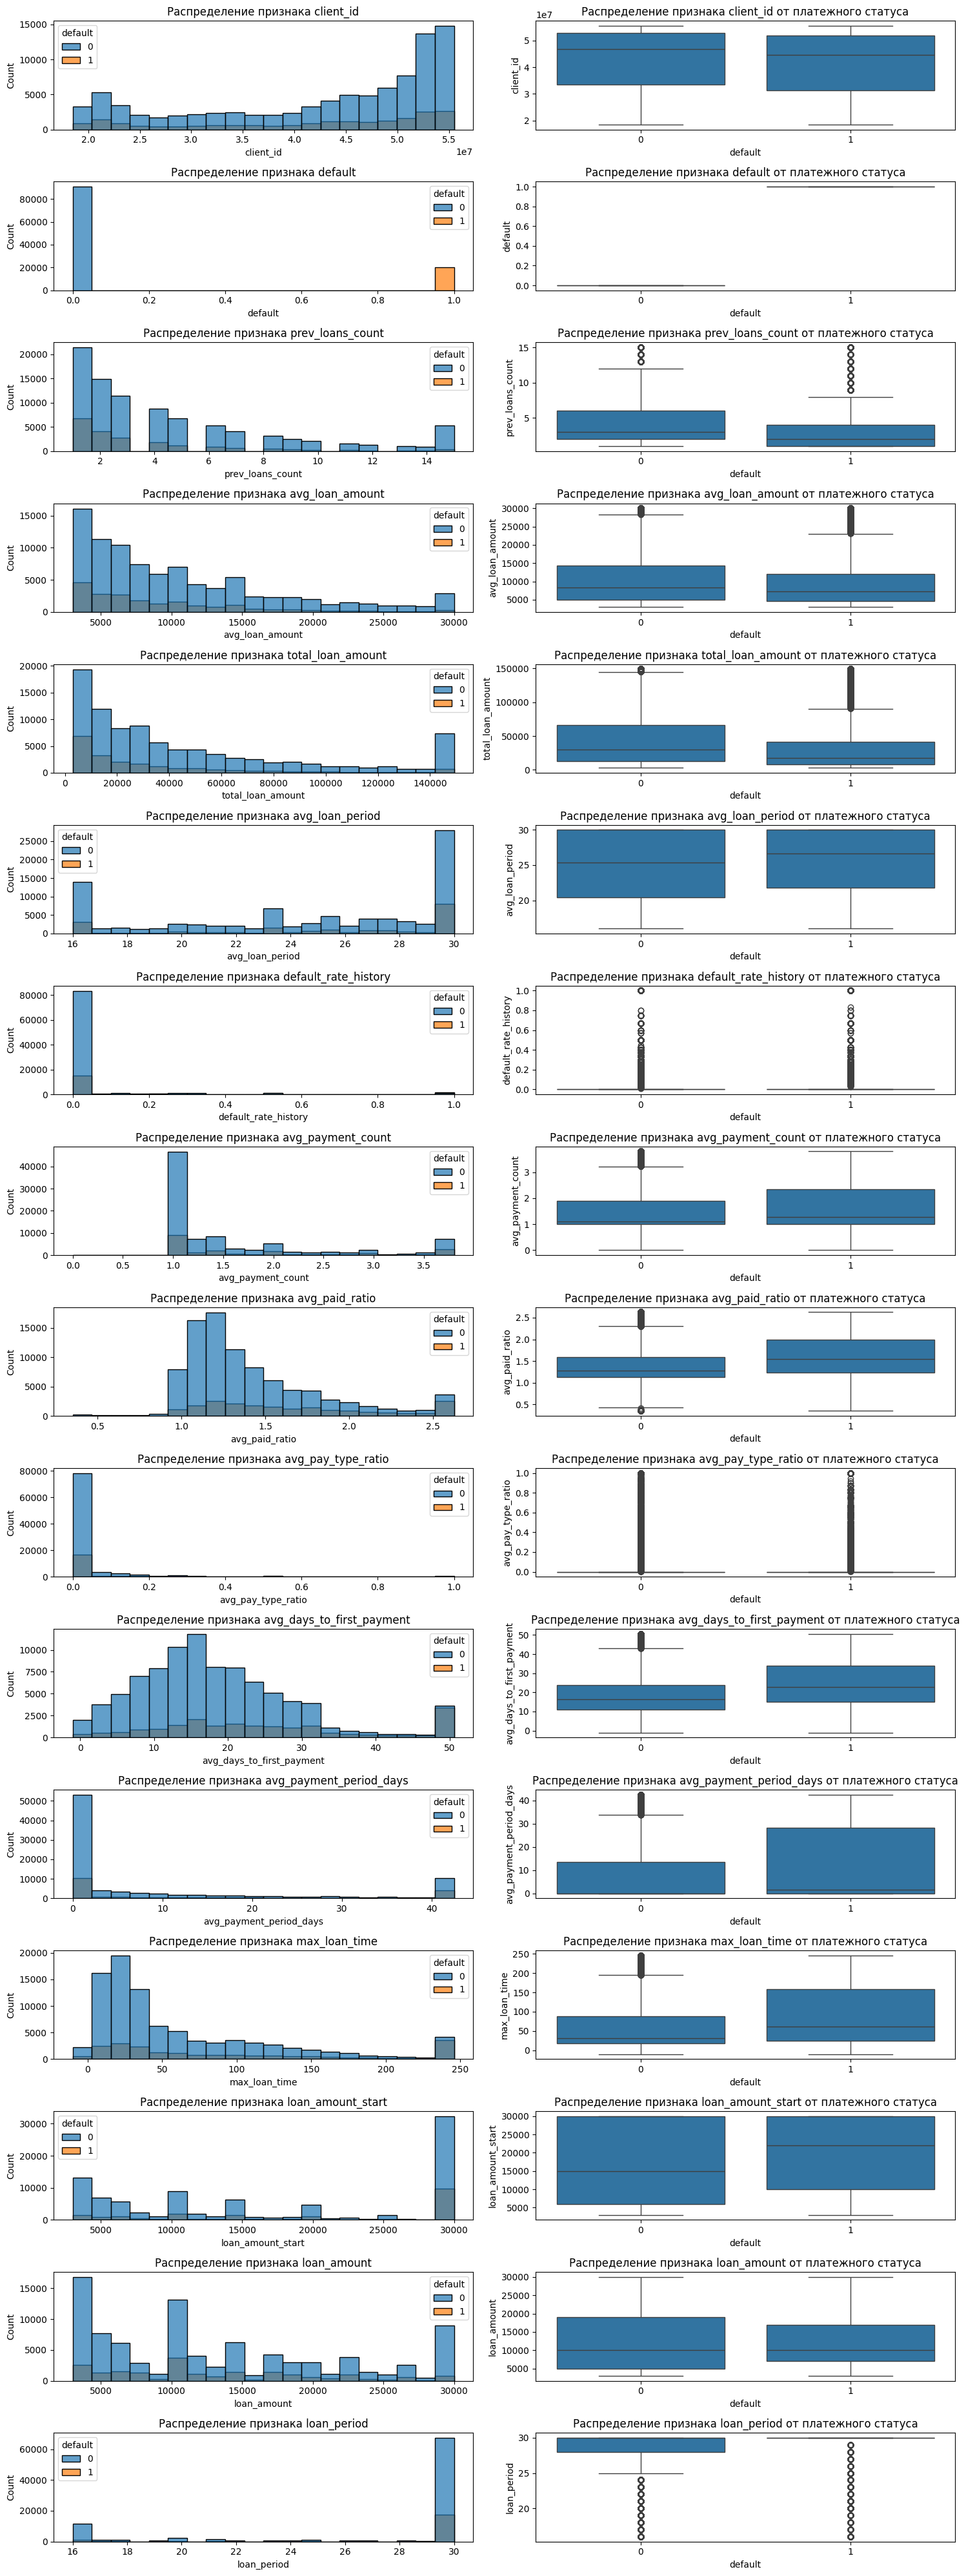

In [46]:
features = capped_data.columns.tolist()

n = len(features) #число  признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) #фигура+n*2 координатных плоскостей
#Создаем цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(features):
    #Строим гисторгамму распределения признака
    histplot = sns.histplot(data=capped_data, x=feature, hue='default', ax=axes[i][0], alpha=0.7, bins=20, kde=False)
    histplot.set_title(f'Распределение признака {feature}')
    #Строим коробчатую диаграмму
    boxplot = sns.boxplot(data=capped_data, x='default', y=feature, ax=axes[i][1])
    boxplot.set_title(f'Распределение признака {feature} от платежного статуса')
    plt.tight_layout() #выравнивание графиков

Распределение признаков стало гораздо лучше, похоже на нормальное или логнормальное. По-хорошему модель должна учиться лучше на таких признаках, но получилось хуже. В итоге учим модели на первоначальных данных. Для сравнения я оставил результаты предсказания для обоих вариантов для модели градиентного бустинга.

# **Часть 2. Обучение и валидация модели**


In [47]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix,classification_report, precision_recall_curve,auc
from sklearn import model_selection
from sklearn.model_selection import RandomizedSearchCV

## 2.1. Обучить модель логистической регрессии и градиентного бустинга на **обучающей выборке**.

### **Разделение на train/test**

Посмотрим на распределение целевой переменной

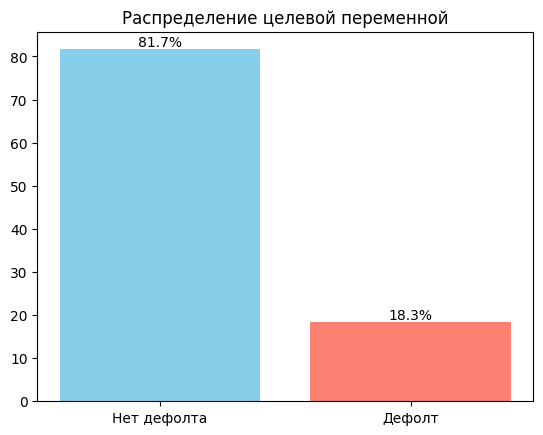

In [48]:
counts = model_data['default'].value_counts(normalize=True)*100
plt.bar(counts.index, counts.values, color=['skyblue', 'salmon'])
plt.xticks([0, 1], ['Нет дефолта', 'Дефолт'])

# Добавляем значения одним вызовом
plt.gca().bar_label(plt.gca().containers[0], fmt='%.1f%%', label_type='edge')

plt.title('Распределение целевой переменной')
plt.show()

ВЫборка имеет неравномерное распределение. Значит чтоб в тест/трейн данные целевая переменная попала в одинаковом соотношении, используем разбиение со стратификацией.

In [49]:
X = model_data.drop(['default'],axis=1)
y = model_data['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.2)

In [50]:
# Выполним масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Преобразуем обратно в DataFrame для удобства
columns = X.columns
X_train_scaled = pd.DataFrame(X_train_scaled, columns=columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=columns, index=X_test.index)

### 2.1.2 **Логистическая регрессия** 

Создадим модель в качестве baseline и оценим по метрике f1-score. 

In [51]:
# Создаем модель
logreg = LogisticRegression(random_state=42, max_iter=1000)

#Обучаем модель
logreg.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred_lr = logreg.predict(X_train_scaled)
print('Train: {:.2f}'.format(f1_score(y_train, y_train_pred_lr)))
y_test_pred_lr = logreg.predict(X_test_scaled)
print('Test: {:.2f}'.format(f1_score(y_test, y_test_pred_lr)))


Train: 0.20
Test: 0.20


Попробуем подобрать гиперпараметры с помощью метода RandomizedSearchCV. 
С помощью этого метода помимо оптимальных гиперпараметорв также получим автоматическое построение новой модели на всем обучающем наборе данных, используя параметры, которые дают наилучшее значение точности при кросс-валидации.  
Так как классы несбалансированы, используем кросс-валидатор StratifiedKFold.   
Получается оценим качество такой модели с помощью кросс-валидации по 3 фолдам.

In [52]:

param_distributions = {'penalty': ['l1','l2', 'none'] ,
              'solver': ['lbfgs', 'saga','newton-cg'],
               'C': list(np.linspace(0.01, 1, 15, dtype=float)),
               'class_weight': [None, 'balanced']}
            
random_search = RandomizedSearchCV(
    estimator=logreg, 
    param_distributions=param_distributions, 
    cv= model_selection.StratifiedKFold(n_splits=3), 
    n_iter = 50, 
    n_jobs = -1
)  

In [53]:
%time random_search.fit(X_train_scaled, y_train) 
y_test_pred = random_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: total: 2.2 s
Wall time: 12.7 s
f1_score на тестовом наборе: 0.20
Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'l2', 'class_weight': None, 'C': 0.29285714285714287}


Значение метрики не изменилось.

Обучим модель на найденных гиперпараметрах и посчитаем более полные метрики качества.

In [54]:
# Создаем модель
logreg = LogisticRegression(
                            solver='saga',
                            penalty='l1',
                            C=0.22,
                            random_state=42,
                            max_iter=1000)
# Обучаем
logreg.fit(X_train_scaled, y_train)
# Делаем предсказания
y__train_pred_logreg = logreg.predict(X_train_scaled)
y__test_pred_logreg = logreg.predict(X_test_scaled)
y_test_pred_proba_logreg = logreg.predict_proba(X_test_scaled)[:, 1]
#Выводим значения метрики чтоб проверить наличие переобучения
print('Train: {:.2f}'.format(f1_score(y_train, y__train_pred_logreg)))
print('Test: {:.2f}'.format(f1_score(y_test, y__test_pred_logreg)))

Train: 0.20
Test: 0.20


Как видим переобучения нет, но значение метрики f1-score как комплексной меры между precision и recall очень низкое. Это связано с неравномерным распределением целевой переменной. Хоть метод RandomizedSearchCV сказал не использовать сбалансированные веса классов - сделаем это. Один из способов обучения модели с неравномерным распределением. Остальные методы попробуем позже.

In [55]:
# Создаем модель т сбалансируем веса
logreg = LogisticRegression(
                            solver='saga',
                            penalty='l1',
                            C=0.22,
                            random_state=42,
                            max_iter=1000,
                            class_weight='balanced')

# Обучаем
logreg.fit(X_train_scaled, y_train)

# Делаем предсказания
y__train_pred_logreg = logreg.predict(X_train_scaled)
y__test_pred_logreg = logreg.predict(X_test_scaled)
y_test_pred_proba_logreg = logreg.predict_proba(X_test_scaled)[:, 1]

#Выводим значения метрики чтоб проверить наличие переобучения
print('Train: {:.2f}'.format(f1_score(y_train, y__train_pred_logreg)))
print('Test: {:.2f}'.format(f1_score(y_test, y__test_pred_logreg)))

Train: 0.43
Test: 0.43


Как видим значение метрики значительно улучшилось. При обучении следующих моделей будем проводить взвешивание классов

In [56]:
# Для более полной оценки метрик на тесттовых данных создадим функцию
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    print(f"=== {model_name} ===")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_true, y_pred_proba):.4f}")
    ROC_AUC = roc_auc_score(y_true, y_pred_proba)
    gini = 2 * ROC_AUC- 1
    print(f'Gini: {gini:.4f}' )
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    print(f"PR-AUC: {pr_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
   

In [57]:
evaluate_model(y_test, y__test_pred_logreg, y_test_pred_proba_logreg, "Logistic Regression")

=== Logistic Regression ===
Accuracy: 0.6925
F1-Score: 0.4266
ROC-AUC: 0.7335
Gini: 0.4670
PR-AUC: 0.3857

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.71      0.79     18133
           1       0.32      0.62      0.43      4074

    accuracy                           0.69     22207
   macro avg       0.61      0.67      0.61     22207
weighted avg       0.79      0.69      0.72     22207



Не стоит смотреть на метрику Accuracy на несбалансированном распределении целевой переменной. Как видим модель определяет 63% дефолтных клиентов, но делает это с 33% точностью. Попробуем обучить более сложную ансамблевую модель.

### 2.1.3 **Градиентный бустинг**

Создадим модель с гиперпараметрами по умаолчанию в качестве baseline и оценим по метрике f1-score.

In [58]:
#Создаем объект класса градиентный бустинг
gbc = GradientBoostingClassifier(random_state=42)
# Больший вес для дефолтов ( вес класса 0 = 1 / 0.82 = 1.22
                           # вес класса 1 = 1 / 0.18 = 5.56)
sample_weights = [1.22 if y == 0 else 5.56 for y in y_train]
#Обучаем модель
gbc.fit(X_train_scaled, y_train, sample_weight=sample_weights)
#Выводим значения метрики 
y_train_pred = gbc.predict(X_train_scaled)
print('Train: {:.2f}'.format(f1_score(y_train, y_train_pred)))
y_test_pred = gbc.predict(X_test_scaled)
print('Test: {:.2f}'.format(f1_score(y_test, y_test_pred)))

Train: 0.45
Test: 0.45


Переобучения нет, попробуем улучшить метрики подобрав гиперпараметры.

Попробуем подобрать гиперпараметры с помощью метода RandomizedSearchCV. 
С помощью этого метода помимо оптимальных гиперпараметорв также получим автоматическое построение новой модели на всем обучающем наборе данных, используя параметры, которые дают наилучшее значение точности при кросс-валидации.  
Так как классы несбалансированы, используем кросс-валидатор StratifiedKFold.   
Получается оценим качество такой модели с помощью кросс-валидации по 3 фолдам.

In [59]:
# cоздадим сетку параметров
param_distributions = {
                'learning_rate': list(np.linspace(0.05, 0.5, 10, dtype=float)),
                'n_estimators': list(np.linspace(100, 500, 9, dtype=int)),
                'min_samples_leaf': list(np.linspace(1, 10, 2, dtype=int)),
                'max_depth': list(np.linspace(1, 7, 7, dtype=int)) 
                        }
            
random_search = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv= model_selection.StratifiedKFold(n_splits=3), 
    n_iter = 50, 
    n_jobs = -1
)  

Дальше при поиске оптимальных гиперпараметров и построении модели с этими параметрами и проверке метрик при кросс-валидации выполнение кода занимает много времени, поэтому я закооментировал эту часть.

In [60]:
#%time random_search.fit(X_train_scaled, y_train) 
#y_train_pred = random_search.predict(X_train_scaled)
#y_test_pred = random_search.predict(X_test_scaled)
#print('f1_score на тестовом наборе: {:.2f}'.format(f1_score(y_train, #y_train_pred)))
#print('f1_score на тестовом наборе: {:.2f}'.format(f1_score(y_test, #y_test_pred)))
#print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

СОздадим модель с подобранными на предыдущем шаге гиперпараметрами чтоб потом с ней работать.

In [61]:
sample_weights = [1.22 if y == 0 else 5.56 for y in y_train]
# Создаем модель
gbc = GradientBoostingClassifier(
                    learning_rate = 0.05, # темп обучения   
                    n_estimators = 200, #количество деревьев в ансамбле
                    min_samples_leaf = 1, # мин количество объектов в листе
                    max_depth = 6, #максимальная глубина дерева
                    random_state = 42,
                    )
# Обучаем
gbc.fit(X_train_scaled, y_train, sample_weight=sample_weights)
# Делаем предсказания
y_train_pred_gbc = gbc.predict(X_train_scaled)
y_test_pred_gbc = gbc.predict(X_test_scaled)
y_test_pred_proba_gbc = gbc.predict_proba(X_test_scaled)[:, 1]
#Выводим значения метрики 

print('Train: {:.2f}'.format(f1_score(y_train, y_train_pred_gbc)))
print('Test: {:.2f}'.format(f1_score(y_test, y_test_pred_gbc)))

Train: 0.49
Test: 0.46


In [62]:
evaluate_model(y_test, y_test_pred_gbc, y_test_pred_proba_gbc, "Gradient Boosting")

=== Gradient Boosting ===
Accuracy: 0.6911
F1-Score: 0.4594
ROC-AUC: 0.7677
Gini: 0.5353
PR-AUC: 0.4259

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.69      0.78     18133
           1       0.34      0.72      0.46      4074

    accuracy                           0.69     22207
   macro avg       0.63      0.70      0.62     22207
weighted avg       0.81      0.69      0.72     22207



А когда обучали модель на capped_data, метрики были:  
=== Gradient Boosting ===  
Accuracy: 0.6827  
F1-Score: 0.4481  
ROC-AUC: 0.7608  
Gini: 0.5215  
PR-AUC: 0.4170  

Classification Report:  

                  precision  recall    f1-score  support

           0       0.91      0.68      0.78     18132
           1       0.33      0.70      0.45      4073

Результаты стали чуть лучше, создадим еще модель случайного леса и проверим метрики на ней.

### 2.1.4 **Модель случайного леса**

Создадим модель с гиперпараметрами по умаолчанию в качестве baseline и оценим по метрике f1-score.

In [63]:
#Создаем объект класса случайный лес
rf = RandomForestClassifier(random_state=42,
                            class_weight='balanced')

#Обучаем модель
rf.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train_scaled)
print('Train: {:.2f}'.format(f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test_scaled)
print('Test: {:.2f}'.format(f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.21


Налицо переобучение, нужно ограничивать эту модель, иначе она будет создавать новые ветви пока не достигнет минимальной энтропии.

Попробуем подобрать гиперпараметры с помощью метода RandomizedSearchCV. 
С помощью этого метода помимо оптимальных гиперпараметорв также получим автоматическое построение новой модели на всем обучающем наборе данных, используя параметры, которые дают наилучшее значение точности при кросс-валидации.  
Так как классы несбалансированы, используем кросс-валидатор StratifiedKFold.   
Получается оценим качество такой модели с помощью кросс-валидации по 3 фолдам.
Аналогично предыдущей модели часть кода закомментирована, т.к. долго выполняется.

In [64]:
param_distributions = {'n_estimators': list(range(80, 300, 30)),
              'min_samples_leaf': [3,5,7,9,11],
              'max_depth': list(np.linspace(5, 40, 10, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv= model_selection.StratifiedKFold(n_splits=3),
    n_iter = 50, 
    n_jobs = -1
)  
#%time random_search_forest.fit(X_train_scaled, y_train) 
#y_train_pred = random_search_forest.predict(X_train_scaled)
#print('f1_score на обучающем наборе: {:.2f}'.format(f1_score(y_train, #y_train_pred)))

#y_test_pred = random_search_forest.predict(X_test_scaled)
#print('f1_score на тестовом наборе: {:.2f}'.format(f1_score(y_test, #y_test_pred)))
#print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

Тогда создадим модель с подобранными гиперпараметравми и оценим метрики.

In [72]:
#Создаем объект класса случайный лес

rf_model = RandomForestClassifier(
    n_estimators=200, #число деревьев
    criterion='gini', #критерий эффективности
    max_depth=12, #максимальная глубина дерева
    min_samples_leaf = 9, # мин кол-во листьев
    max_features='sqrt', #число признаков из метода случайных подространств
    random_state=42, #генератор случайных чисел
    class_weight='balanced'
)
#Обучаем модель
rf_model.fit(X_train_scaled, y_train)

# Делаем предсказания
y_train_pred_rf = rf_model.predict(X_train_scaled)
y__test_pred_rf = rf_model.predict(X_test_scaled)
y_test_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]
#Выводим значения метрики 

print('Train: {}'.format(classification_report(y_train, y_train_pred_rf)))
print('Test: {}'.format(classification_report(y_test, y__test_pred_rf)))

Train:               precision    recall  f1-score   support

           0       0.93      0.74      0.82     72531
           1       0.39      0.74      0.51     16293

    accuracy                           0.74     88824
   macro avg       0.66      0.74      0.66     88824
weighted avg       0.83      0.74      0.76     88824

Test:               precision    recall  f1-score   support

           0       0.90      0.72      0.80     18133
           1       0.35      0.66      0.45      4074

    accuracy                           0.71     22207
   macro avg       0.62      0.69      0.63     22207
weighted avg       0.80      0.71      0.74     22207



In [66]:
evaluate_model(y_test, y__test_pred_rf, y_test_pred_proba_rf, "Random Forest")


=== Random Forest ===
Accuracy: 0.7083
F1-Score: 0.4526
ROC-AUC: 0.7599
Gini: 0.5198
PR-AUC: 0.4124

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80     18133
           1       0.35      0.66      0.45      4074

    accuracy                           0.71     22207
   macro avg       0.62      0.69      0.63     22207
weighted avg       0.80      0.71      0.74     22207



### 2.1.5 **Стекинг** 
Попробуем использовать стекинг, объединив те алгоритмы, которые уже использовали ранее: логистическую регрессию, градиентный бустинг и случаный лес. В качестве метамодели используем модель логистической регрессии.Гиперпараметры задавать не будем, т.к. логистическая регрессия мало зависит от них и параметры по умолчанию подобраны разумно.

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import StackingClassifier

In [73]:
# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('log_reg', logreg),
    ('rf',  rf_model),
    ('gbc', gbc)
]

# Создаем объект класса стекинг
stack_lr = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(random_state=42,
                                       class_weight='balanced')
)
# Обучаем модель
stack_lr.fit(X_train_scaled, y_train)

StackingClassifier(estimators=[('log_reg',
                                LogisticRegression(C=0.22,
                                                   class_weight='balanced',
                                                   max_iter=1000, penalty='l1',
                                                   random_state=42,
                                                   solver='saga')),
                               ('rf',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=12,
                                                       min_samples_leaf=9,
                                                       n_estimators=200,
                                                       random_state=42)),
                               ('gbc',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=6,
                                                           n_estimators=200,
                                                           random_state=42))],
                   final_estimator=LogisticRegression(class_weight='balanced',
                                                      random_state=42))

In [74]:
# Делаем предсказания
y_train_pred_stack = stack_lr.predict(X_train_scaled)
y_test_pred_stack = stack_lr.predict(X_test_scaled)
y_test_pred_proba_stack = stack_lr.predict_proba(X_test_scaled)[:, 1]

#Выводим значения метрики 
print('Train: {:.2f}'.format(f1_score(y_train, y_train_pred_stack)))
print('Test: {:.2f}'.format(f1_score(y_test, y_test_pred_stack)))

Train: 0.50
Test: 0.45


In [75]:
evaluate_model(y_test, y_test_pred_stack, y_test_pred_proba_stack, "Stacking_Log_Reg")

=== Stacking_Log_Reg ===
Accuracy: 0.6921
F1-Score: 0.4533
ROC-AUC: 0.7642
Gini: 0.5283
PR-AUC: 0.4207

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.69      0.79     18133
           1       0.34      0.70      0.45      4074

    accuracy                           0.69     22207
   macro avg       0.62      0.69      0.62     22207
weighted avg       0.80      0.69      0.72     22207



## 2.2. Выбор модели:  
При выборе будем ориентироаться на метрику f1-score, как комплексно отражающую precision и recall, а также PR-AUC, как площать под кривой precision-recall.    
В условиях несбалансированно распределенной целевой переменной не будем ориентироваться на высокий показатель метрики Accuracy, т.к. она просто хорошо предсказывает недефолтных клиентов (хотя после взвешивания классов метрика стала объективнее).
В нашем случае лучшие метрики качества показывает модель градиентого бустинга.
Итак, что можно сказать по ней:
* **Recall**   
Подобрав веса классов удалось достичь хороших резудьтатов по выявлению дефолтных клиентов. Recall = 0.72. О чем это говорит? Из всех клиентов модель верно определяет 72%. Хороший результат. 
* **Precision**   
Сбалансировав веса классов мы повысили охват, но точность снизилась до 0.34. Это закономерный процесс, стало больше значений, из которых нужно выбирать True Positive, но по сути когда модель говорит "дефолт", она права только в 34% случаев, а 66% добросоветсных клиентов получают отказ. Попробуем исправить это изменением порога вероятности отнесения к классу 1.
* **F1-score**   
 F1-score = 0.46, что говорит о хорошем что балансе между Precision и Recall. 
* **PR-AUC**   
В условиях несбалансированного распределения эта метрика более актуальна, т.к. в отличие от F1-score учитвает все возможные пороги вероятности (интеграл под всей PR-кривой). Знчение = 0,43 говорит о том, что в целом модель имеет умеренное, но стабильное качество обнаружения дефолтов при любых порогах.
* **AUC-ROC и Gini** 
Метрики ROC-AUC = 0.77 и Gini: 0.54 говорят о том, модель хорошо ранжирует клиентов по риску, т.е. модель можно использовать для сортировки клиентов на группы риска и использовать дифференцированный подход при выдаче займов (если взять случайного покупателя и случайного непокупателя, то в 77% случаев модель присвоит покупателю более высокую вероятность, чем непокупателю).  



### Подбор порога вероятности с помощью PR-кривой.

Попробуем повысить точность определения дефолтных клиентов (Precision). Используем метод подбора порога вероятности с помощью PR-кривой.  
Порог вероятности будем подбирать с помощью кросс-валидации.  
Построим PR-кривую и отметим на ней точку, в которой наблюдается максимум метрики для дефолтных клиентов.   
Там же укажем порог вероятности, соответствующий этой точке.

Best threshold = 0.58, F1-Score = 0.51


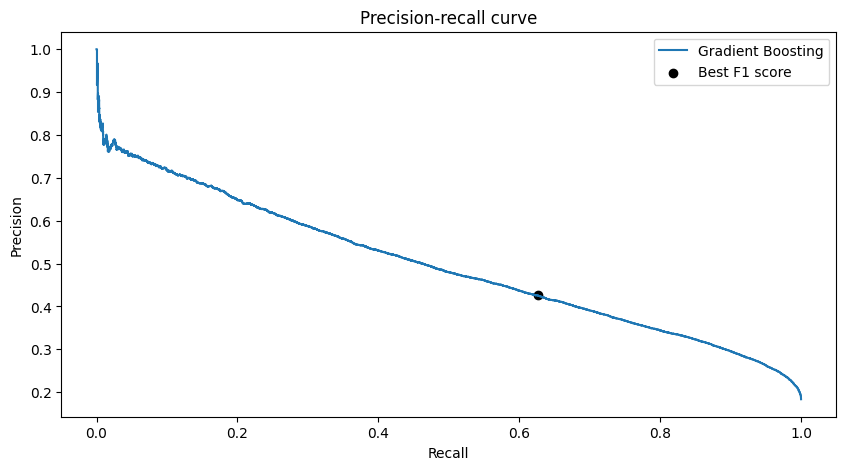

In [76]:
#Делаем предсказание вероятностей и выделяем столбец с вероятностями для класса 1
y_train_pred_proba_gbc = gbc.predict_proba(X_train_scaled)[:, 1]

#Вычисляем координаты PR-кривой
precision, recall, thresholds = precision_recall_curve(y_train, y_train_pred_proba_gbc)

#Вычисляем F1-меру при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
#Определяем индекс максимума
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))

#Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим линейный график зависимости precision от recall
ax.plot(recall, precision, label='Gradient Boosting')
#Отмечаем точку максимума F1
ax.scatter(recall[idx], precision[idx], marker='o', color='black', label='Best F1 score')
#Даем графику название и подписи осям
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
#Отображаем легенду
ax.legend();

In [77]:
#Задаём оптимальный порог вероятностей
threshold_opt = 0.58
# Клиенты, для которых вероятность дефолта > threshold_opt, относим к классу 1
#В противном случае — к классу 0
y_valid_pred_proba = gbc.predict_proba(X_test_scaled)[:, 1]
y_valid_pred = (y_valid_pred_proba > threshold_opt).astype('int')
#Считаем метрики
print(classification_report(y_test, y_valid_pred))

              precision    recall  f1-score   support

           0       0.89      0.79      0.84     18133
           1       0.39      0.58      0.47      4074

    accuracy                           0.76     22207
   macro avg       0.64      0.69      0.65     22207
weighted avg       0.80      0.76      0.77     22207



При пороге вероятности 0.58 F1-score даже немного вырос, охват упал (мы стали определять только 58% дефолтных клиентов), но зато делаем это более точно (делаем меньше ложных отказов). Оставлять такой порог или нет зависит от задачи, что главное, а что вторичное. Если цель - находить дефолты и минимизировать потери денег - то первый вариант модели лучше, а если важнее максимизировать прибыль, меньше отказывая хорошим клиентам, то этот вариант модели будет лучше.

### Сэмплирование


Попробуем еще сэмплирование, вдруг получится улушить метрики. Увеличим кол-во данных в миноритарной выборке.

In [78]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2)
X_train_s, y_train_s = sm.fit_resample(X_train_scaled, y_train)

print('Train shape before oversampling:', X_train.shape) 
print('Class balance before oversampling: \n', y_train.value_counts(), sep='')
print('-'*40)
print('Train shape after oversampling:', X_train_s.shape)
print('Class balance after oversampling: \n', y_train_s.value_counts(), sep='')

Train shape before oversampling: (88824, 15)
Class balance before oversampling: 
default
0    72531
1    16293
Name: count, dtype: int64
----------------------------------------
Train shape after oversampling: (145062, 15)
Class balance after oversampling: 
default
1    72531
0    72531
Name: count, dtype: int64


Обучим модель на увеличенной выборке. Одновременно сбалансируем веса, без этого метрики получаются гораздо хуже, уже проверил.

In [79]:
sample_weights = [1.22 if y == 0 else 3 for y in y_train_s]
# Создаем модель
gbc = GradientBoostingClassifier(
                    learning_rate = 0.05, # темп обучения   
                    n_estimators = 200, #количество деревьев в ансамбле
                    min_samples_leaf = 1, # мин количество объектов в листе
                    max_depth = 6, #максимальная глубина дерева
                    random_state = 42,
                    )
# Обучаем
gbc.fit(X_train_s, y_train_s, sample_weight=sample_weights)
# Делаем предсказания
y_train_pred_gbc_s = gbc.predict(X_train_scaled)
y_test_pred_gbc_s = gbc.predict(X_test_scaled)
y_test_pred_proba_gbc_s = gbc.predict_proba(X_test_scaled)[:, 1]

#Выводим значения метрики 
print('Train: {:.2f}'.format(f1_score(y_train, y_train_pred_gbc_s)))
print('Test: {:.2f}'.format(f1_score(y_test, y_test_pred_gbc_s)))

Train: 0.46
Test: 0.44


In [80]:
evaluate_model(y_test, y_test_pred_gbc_s, y_test_pred_proba_gbc_s, "Gradient Boosting")

=== Gradient Boosting ===
Accuracy: 0.6558
F1-Score: 0.4390
ROC-AUC: 0.7530
Gini: 0.5061
PR-AUC: 0.4013

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.64      0.75     18133
           1       0.31      0.73      0.44      4074

    accuracy                           0.66     22207
   macro avg       0.61      0.69      0.60     22207
weighted avg       0.80      0.66      0.69     22207



Сэмплированием результаты улучшить не удалось, получили примерно то же самое, оставляем предыдущую модель.

## 2.3. Для выбранной модели провести анализ наиболее информативных признаков.

In [81]:
# Посмотрим на коэффициенты важности признаков
gbc.feature_importances_

array([0.01733711, 0.2338966 , 0.03185303, 0.03586638, 0.01343157,
       0.0255662 , 0.0356118 , 0.03664742, 0.01226078, 0.09601529,
       0.00444758, 0.0658896 , 0.15138279, 0.19236946, 0.04742438])

In [82]:
X_train_scaled.columns

Index(['client_id', 'prev_loans_count', 'avg_loan_amount', 'total_loan_amount',
       'avg_loan_period', 'default_rate_history', 'avg_payment_count',
       'avg_paid_ratio', 'avg_pay_type_ratio', 'avg_days_to_first_payment',
       'avg_payment_period_days', 'max_loan_time', 'loan_amount_start',
       'loan_amount', 'loan_period'],
      dtype='object')

Видим, что наиболее важными признками являются avg_days_to_first_payment, затем loan_amount_start, total_loan_amount,avg_paid_ratio и max_loan_time.
Напомним что это за признаки:
* avg_days_to_first_payment - среднее количество дней до первого платежа
* loan_amount_start - запрашиваемая сумма
* total_loan_amount - общая сумма всех займов
* avg_paid_ratio -  средняя доля погашения займов
* max_loan_time - максимальное время займа (разница между датой зактырия и открытия)

## 2.3.1. Среднее количество дней до первого платежа

Этот признак является самым информативным для модели. Выполним визуализацию. Изобразим 4 графика:
1) гистограмму абсолютного распределения признака (количество) в разрезе статуса по последнему займу
2) гистограмму относительного распределения признака (количество) в разрезе статуса по последнему займу (и каждую группу будем нормировать отдельно)
3) разделим признак на части, постоим столбчатую диаграмму и посмотрим на долю дефолтов по последнему займу по этим частям
4) боксплот для сравнения средних сроков платежа в разрезе статуса клиента по последнему займу

Я думаю эти визуализации хорошо помогут проанализировать признак.  
По **графику 1** увидим распределение значения признака на кредитной истории в разрезе статуса клиента по последнему займу в абсолютных значениях (кол-ве клиентов), а **график 3** под ним, разбитый на такое же кол-во бинов даст понимание доли дефолтов в каждом бине графика 1.  
На **графике 2** будет изображено относительное распределение признака (доля клиентов), причем дефолтные и недефолтные клиенты будут нормированы отдельно, это даст возможность лучшего понимания распределения дефолтных, т.к. классы несбалансированы. Это позволит оценить как соотносятся между собой эти два распределения, совпадают или одно смещено относительно другого.  
Ну и по **графику 4** сможем оценить центральную тенденцию, разброс и выбросы для каждого из классов, что удобно для сравнения и поиска отличий.

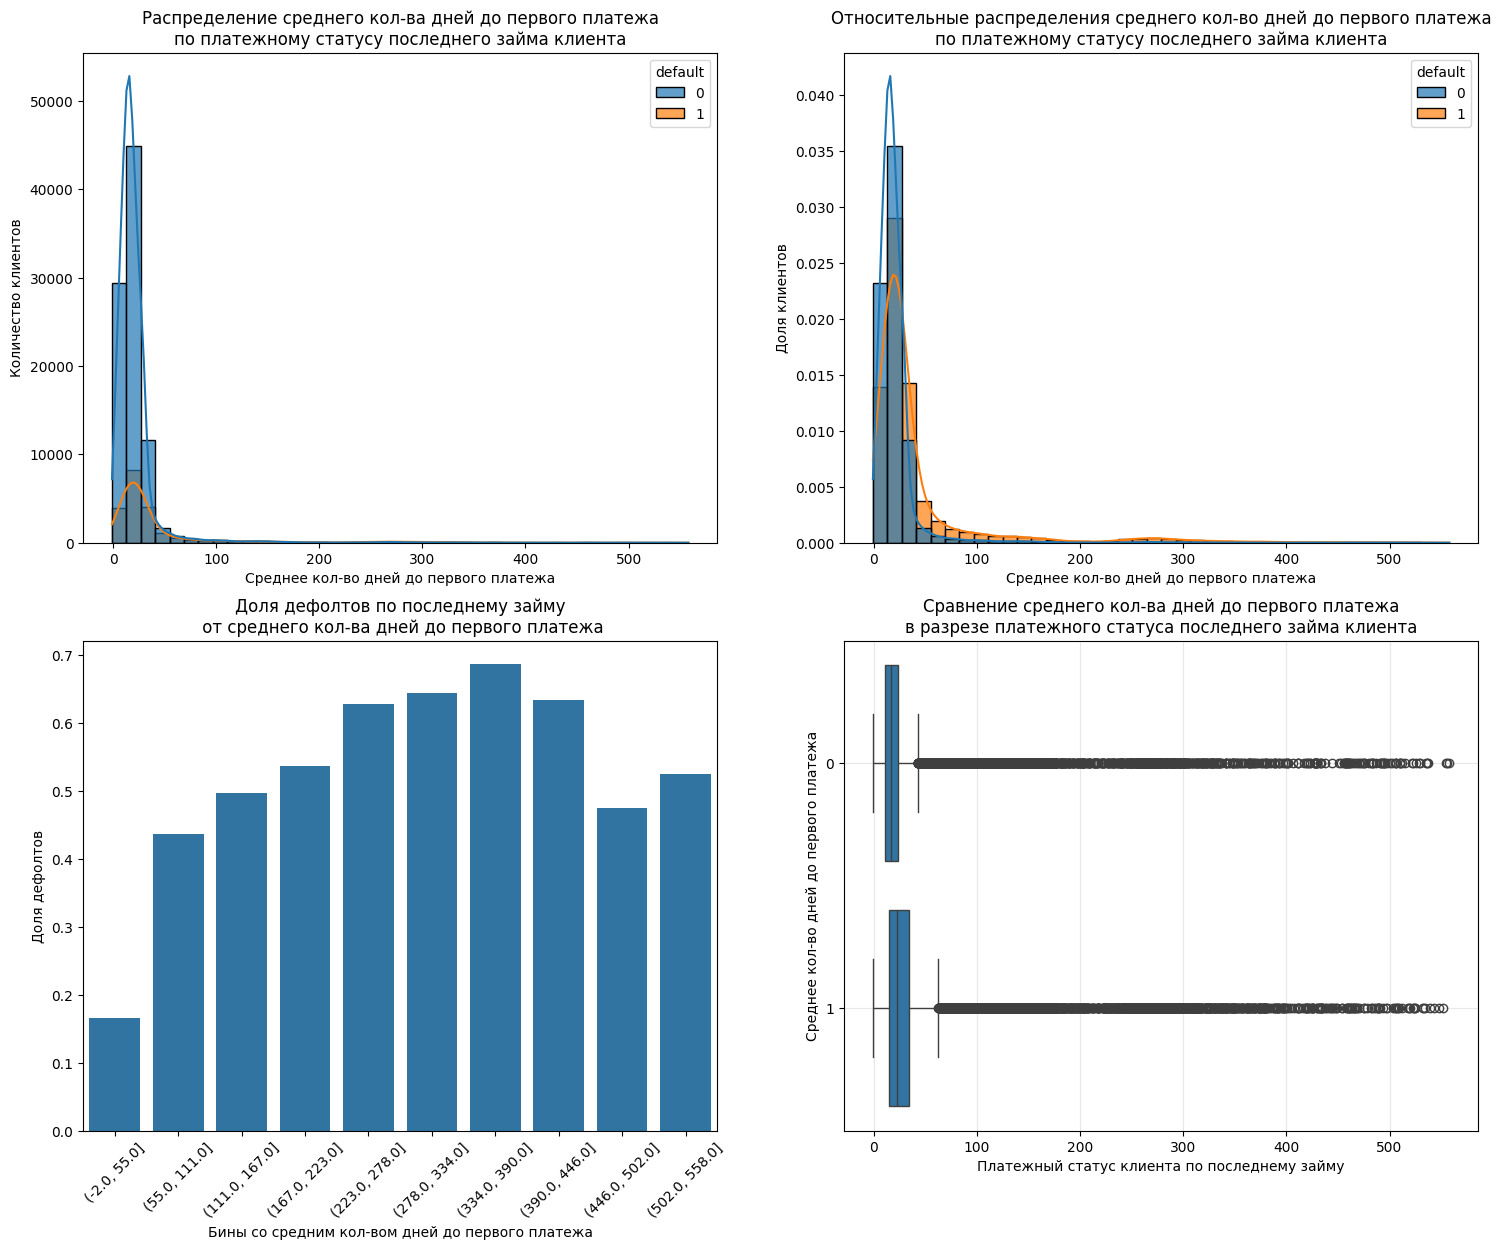

In [83]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Гистограмма
sns.histplot(data=model_data, x='avg_days_to_first_payment', hue='default', kde=True, ax=axes[0][0], alpha=0.7, bins=40)
axes[0][0].set_title('Распределение среднего кол-ва дней до первого платежа' + '\n' + 'по платежному статусу последнего займа клиента')
axes[0][0].set_xlabel('Среднее кол-во дней до первого платежа')  
axes[0][0].set_ylabel('Количество клиентов') 

# Гистограмма
sns.histplot(data=model_data, x='avg_days_to_first_payment', hue='default', kde=True, ax=axes[0][1], alpha=0.7, bins=40,stat='density', common_norm=False)
axes[0][1].set_title('Относительные распределения среднего кол-во дней до первого платежа' + '\n' + 'по платежному статусу последнего займа клиента')
axes[0][1].set_xlabel('Среднее кол-во дней до первого платежа')  
axes[0][1].set_ylabel('Доля клиентов')

# Боксплот
sns.boxplot(data=model_data, y='default', x='avg_days_to_first_payment', ax=axes[1][1],orient='h')
axes[1][1].set_title('Сравнение среднего кол-ва дней до первого платежа' + '\n' + 'в разрезе платежного статуса последнего займа клиента')
axes[1][1].set_ylabel('Среднее кол-во дней до первого платежа')  
axes[1][1].set_xlabel('Платежный статус клиента по последнему займу')
#axes[1][1].set_xticks(np.arange(0, 60, 2))
axes[1][1].grid(True, alpha=0.3) 

model_data_copy = model_data.copy()
# Разобьем на 10 частей и посмотрим дефолты в них
model_data_copy['loan_bins'] = pd.cut(model_data['avg_days_to_first_payment'], bins=10,precision=0)
default_rate = model_data_copy.groupby('loan_bins')['default'].mean()
sns.barplot(x=default_rate.index.astype(str), y=default_rate.values, ax=axes[1][0])
axes[1][0].set_title('Доля дефолтов по последнему займу' + '\n' + ' от среднего кол-ва дней до первого платежа')
axes[1][0].tick_params(axis='x', rotation=45)
axes[1][0].set_ylabel('Доля дефолтов')  
axes[1][0].set_xlabel('Бины со средним кол-вом дней до первого платежа');

В таком масштабе не очень видно, а логарифмическую шкалу тут не применишь, т.к. есть клиенты без платежей и со средним сроком первого платежа 0 дней, а логарифм от числа меньше 0 взять нельзя. Поэтому чтобы лучше понять распределение построим то же самое, только возьмем период поменьше, где данные наиболее сконцентрированы. Надо понимать, что мы уже берем выборку из генеральной совокупности, и значения медиан, квартилей, относительных величин будут рассчитаны относительно этого объема данных.

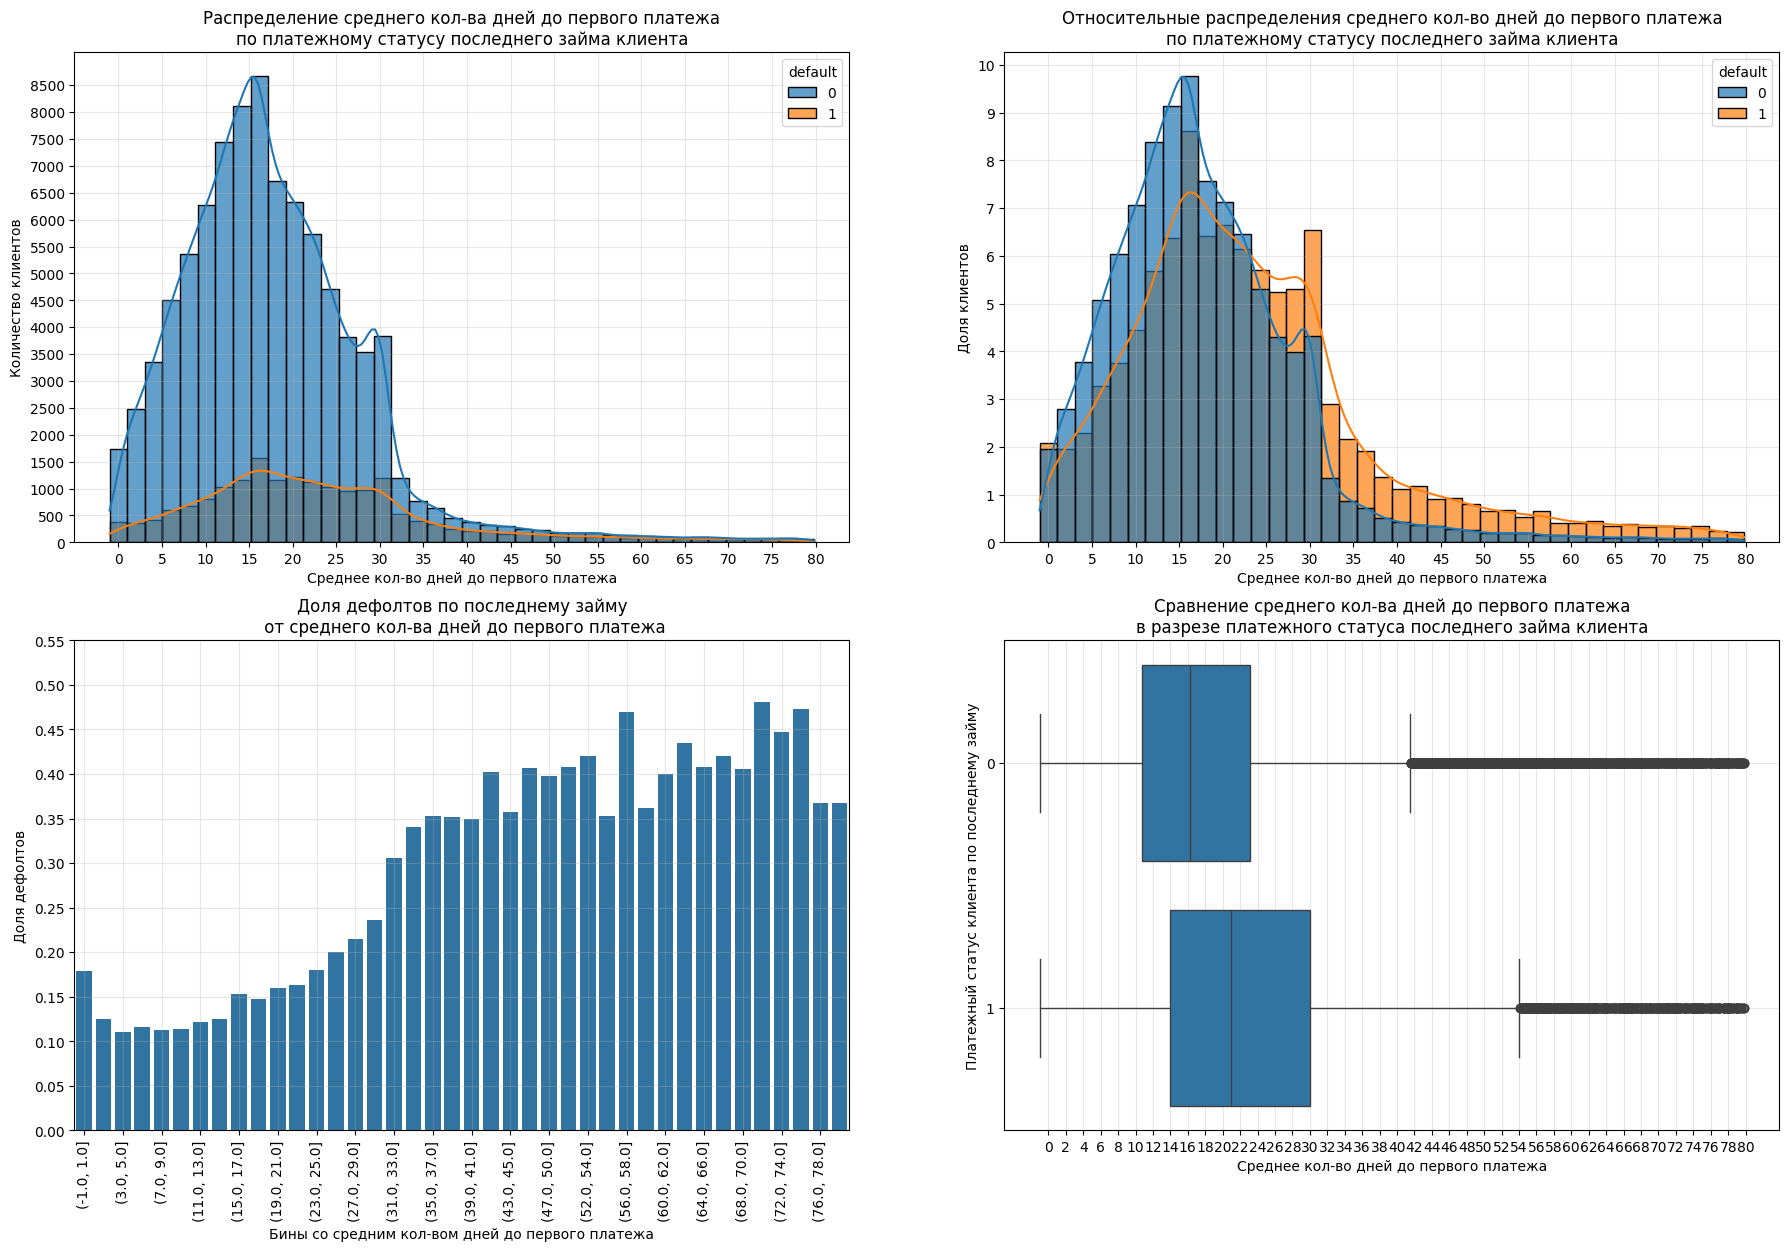

In [84]:
fig, axes = plt.subplots(2, 2, figsize=(22, 14))

# Гистограмма
sns.histplot(data=model_data[model_data['avg_days_to_first_payment'] < 80], x='avg_days_to_first_payment', hue='default', kde=True, ax=axes[0][0], alpha=0.7, bins=40)
axes[0][0].set_title('Распределение среднего кол-ва дней до первого платежа' + '\n' + 'по платежному статусу последнего займа клиента')
axes[0][0].set_xlabel('Среднее кол-во дней до первого платежа') 
axes[0][0].set_xticks(np.arange(0, 81, 5)) 
axes[0][0].set_ylabel('Количество клиентов') 
axes[0][0].set_yticks(np.arange(0, 8600, 500))
axes[0][0].grid(True, alpha=0.3)

# Гистограмма
sns.histplot(data=model_data[model_data['avg_days_to_first_payment'] < 80], x='avg_days_to_first_payment', hue='default', kde=True, ax=axes[0][1], alpha=0.7, bins=40,stat='percent', common_norm=False)
axes[0][1].set_title('Относительные распределения среднего кол-во дней до первого платежа' + '\n' + 'по платежному статусу последнего займа клиента')
axes[0][1].set_xlabel('Среднее кол-во дней до первого платежа')  
axes[0][1].set_xticks(np.arange(0, 81, 5))
axes[0][1].set_ylabel('Доля клиентов')
axes[0][1].set_yticks(np.arange(0, 11, 1))
axes[0][1].grid(True, alpha=0.3)

# Боксплот
sns.boxplot(data=model_data[model_data['avg_days_to_first_payment'] < 80], y='default', x='avg_days_to_first_payment', ax=axes[1][1],orient='h')
axes[1][1].set_title('Сравнение среднего кол-ва дней до первого платежа' + '\n' + 'в разрезе платежного статуса последнего займа клиента')
axes[1][1].set_xlabel('Среднее кол-во дней до первого платежа')
axes[1][1].set_xticks(np.arange(0, 81, 2))
#axes[1][1].set_xticklabels(np.arange(0, 81, 2), rotation=90, ha='right') 
axes[1][1].set_ylabel('Платежный статус клиента по последнему займу') 
axes[1][1].grid(True, alpha=0.3)


model_data_copy = model_data.copy()
# Разобьем на 10 частей и посмотрим дефолты в них
model_data_copy['loan_bins'] = pd.cut(model_data[model_data['avg_days_to_first_payment'] < 80]['avg_days_to_first_payment'], bins=40,precision=0)
default_rate = model_data_copy.groupby('loan_bins')['default'].mean()
sns.barplot(x=default_rate.index.astype(str), y=default_rate.values, ax=axes[1][0])
axes[1][0].set_title('Доля дефолтов по последнему займу' + '\n' + ' от среднего кол-ва дней до первого платежа')
axes[1][0].tick_params(axis='x', rotation=45)
axes[1][0].set_yticks(np.arange(0, 0.6, 0.05))
axes[1][0].grid(True, alpha=0.3)
ticks_positions = range(0, len(default_rate.index), 2)
ticks_labels = [str(default_rate.index[i]) for i in ticks_positions]
axes[1][0].set_xticks(ticks_positions)
axes[1][0].set_xticklabels(ticks_labels, rotation=90)
axes[1][0].set_ylabel('Доля дефолтов')  
axes[1][0].set_xlabel('Бины со средним кол-вом дней до первого платежа');

Еще один момент о чем говорил выше - все таки для корректной оценки квартилей нужно построить отдельный боксплот на полных данных, потому что ограничивая выборку для мажоританого класса эти данные могут не сместиться, а для миноритарного могут, т.к. они чаще и находятся в том "хвосте", который мы ограничили. Для лучшего мастшаба используем метод showfliers=False, он покажет боксплот без выбросов, но построен на полных данных.

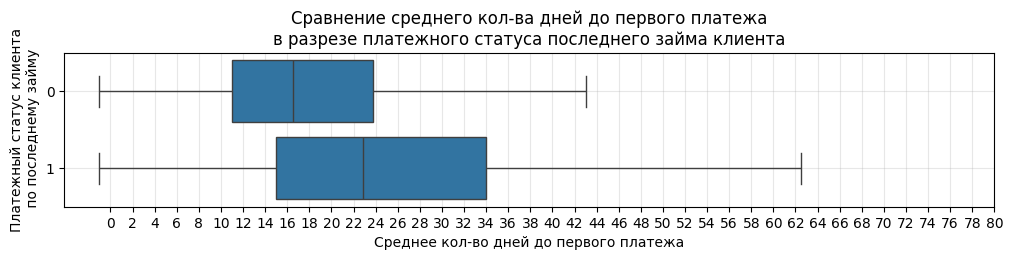

In [85]:
fig, axes = plt.subplots(1, 1, figsize=(12, 2))
# Боксплот
sns.boxplot(data=model_data, y='default', x='avg_days_to_first_payment', ax=axes,orient='h', showfliers=False)
axes.set_title('Сравнение среднего кол-ва дней до первого платежа' + '\n' + 'в разрезе платежного статуса последнего займа клиента')
axes.set_xlabel('Среднее кол-во дней до первого платежа')
axes.set_xticks(np.arange(0, 81, 2))
#axes[1][1].set_xticklabels(np.arange(0, 81, 2), rotation=90, ha='right') 
axes.set_ylabel('Платежный статус клиента' + '\n' + ' по последнему займу') 
axes.grid(True, alpha=0.3)

Первое что можно отметить, это то, что в среднем большинство клиентов совершает первый платеж в течение 30 дней, что логично, они не хотят уйти в дефолт. При этом даже то, что обычно клиент делает первый платеж в течение 30 дней, не гарантирует отсутствие дефолта по последнему займу. Как видим такие случаи наблюдаются, однако доля таких случаев в первые 30 дней меньше 23% (первые 15 дей окло 12%, потом плавно растет к 23%). После 30 дней видим резкое снижение платежей, а количество дефолтов резко увеличивается до 30+%. В более поздние сроки после (30 дня) количество первых платежей на кредитной истории падает (1 график), доля дефотлов становится на уровне 35-45% (3 график), а по графику 2 видим, что если сделать относительное распределение дефолтов, то как раз на 30 день приходится скачок дефолтов (платежей в среднем меньше, а дефолтов больше). И далее по графику 2 видно, что распределение дефолтов смещено вправо относительно не дефолтов, т.е. с учеличением сроков дефолтов больше.  
Из графиков в полном масштабе только 3 будет полезен. Видим, что при платежах более 55 дней доля дефотов растет до 60-70%, т.е. те, кто в кредитной истории платил позже и на последнем займе имеют огномную долю дефолтов.  
По последнему боксплоту видим, что:  
Дефолтные: Q1=15, Медиана=23, Q3=34 дня  
Недефолтные: Q1=11, Медиана=16, Q3=24 дня  
Т,е. у клиентов, у которых по последнему платежу нет дефолта, исторически делают первый платеж раньше (до 16 дней платят 50% недефолтных, а дефолтных только 25%. до 24 дней совершают платеж 75% недефолтных, а дефолтных только половина). Это видно и на графике 3, после 23 дня доля дефолтов резко возрастает.

Для этого признака и далее будем в качестве вывода формировать зоны по степени риска. Это поможет потом дать некий алгоритм для формирования суммы займа клиенту. 
Для признака avg_days_to_first_payment:
* avg_days_to_first_payment <= 11 - низкий риск,
* 11 < avg_days_to_first_payment <= 16 - средний,
* 16 < avg_days_to_first_payment <= 23 - повышенный,
* avg_days_to_first_payment > 23 - высокий.

## 2.3.2 Запрашиваемая сумма

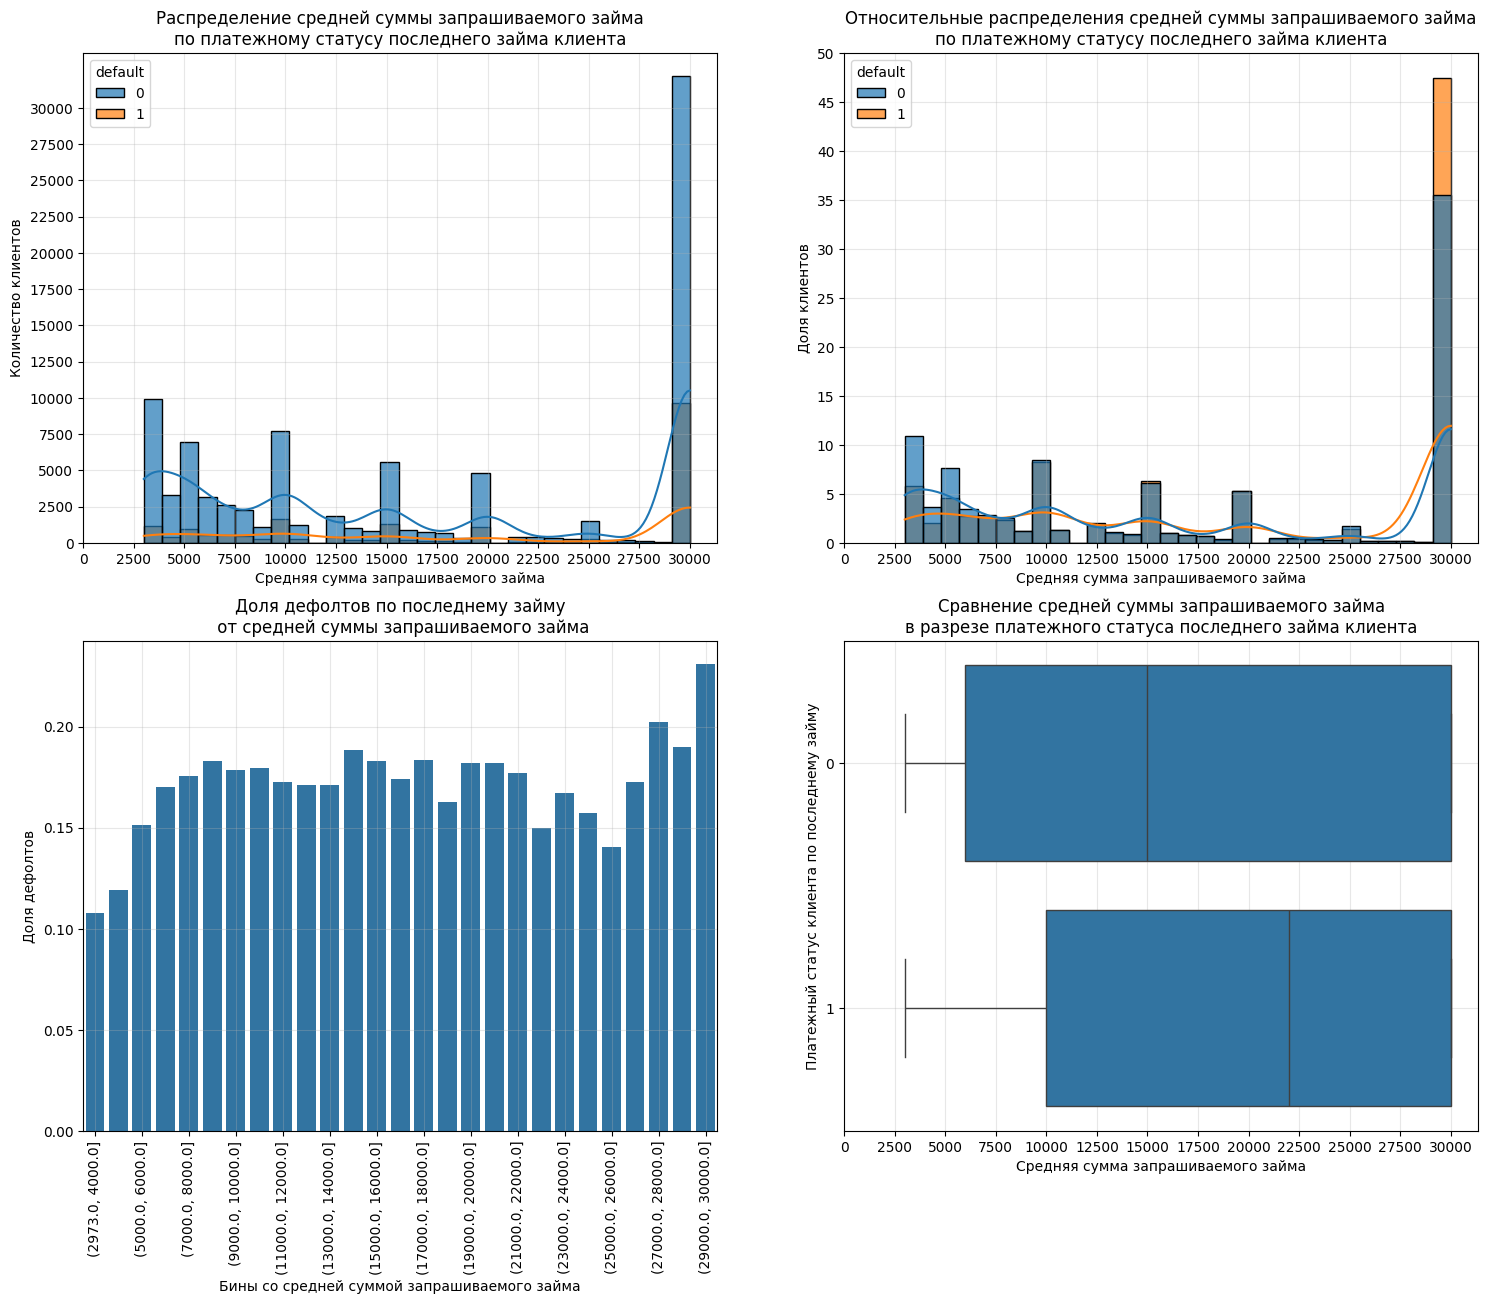

In [86]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Гистограмма абсольтная
sns.histplot(data=model_data, x='loan_amount_start', hue='default', kde=True, ax=axes[0][0], alpha=0.7, bins=30)
axes[0][0].set_title('Распределение средней суммы запрашиваемого займа' + '\n' + 'по платежному статусу последнего займа клиента')
axes[0][0].set_xlabel('Средняя сумма запрашиваемого займа') 
axes[0][0].set_xticks(np.arange(0, 30001, 2500)) 
axes[0][0].set_ylabel('Количество клиентов') 
axes[0][0].set_yticks(np.arange(0, 30001, 2500))
axes[0][0].grid(True, alpha=0.3)

# Гистограмма относительная
sns.histplot(data=model_data, x='loan_amount_start', hue='default', kde=True, ax=axes[0][1], alpha=0.7, bins=30,stat='percent', common_norm=False)
axes[0][1].set_title('Относительные распределения средней суммы запрашиваемого займа' + '\n' + 'по платежному статусу последнего займа клиента')
axes[0][1].set_xlabel('Средняя сумма запрашиваемого займа')  
axes[0][1].set_xticks(np.arange(0, 30001, 2500)) 
axes[0][1].set_ylabel('Доля клиентов')
axes[0][1].set_yticks(np.arange(0, 51, 5))
axes[0][1].grid(True, alpha=0.3)

# Боксплот
sns.boxplot(data=model_data, y='default', x='loan_amount_start', ax=axes[1][1],orient='h')
axes[1][1].set_title('Сравнение средней суммы запрашиваемого займа' + '\n' + 'в разрезе платежного статуса последнего займа клиента')
axes[1][1].set_xlabel('Средняя сумма запрашиваемого займа')
axes[1][1].set_xticks(np.arange(0, 30001, 2500)) 
axes[1][1].set_ylabel('Платежный статус клиента по последнему займу') 
axes[1][1].grid(True, alpha=0.3)


model_data_copy = model_data.copy()
# Разобьем на 10 частей и посмотрим дефолты в них
model_data_copy['loan_bins'] = pd.cut(model_data['loan_amount_start'], bins=27,precision=0)
default_rate = model_data_copy.groupby('loan_bins')['default'].mean()
sns.barplot(x=default_rate.index.astype(str), y=default_rate.values, ax=axes[1][0])
axes[1][0].set_title('Доля дефолтов по последнему займу' + '\n' + ' от средней суммы запрашиваемого займа')
axes[1][0].tick_params(axis='x', rotation=20)
axes[1][0].grid(True, alpha=0.3)
ticks_positions = range(0, len(default_rate.index), 2)
ticks_labels = [str(default_rate.index[i]) for i in ticks_positions]
axes[1][0].set_xticks(ticks_positions)
axes[1][0].set_xticklabels(ticks_labels, rotation=90)
axes[1][0].set_ylabel('Доля дефолтов')  
axes[1][0].set_xlabel('Бины со средней суммой запрашиваемого займа');

Из 1 графика сделаем вывод, что клиенты большинство клиентов запрашивают максимальный размер займа. Около 10 % берут минимальный займ, а так же предпочитают брать суммы займов, кратные 5000. Также по 2 графику видим, что почти 50 % всех клиентов с дефолтом запрашивают максималный размер займа. По графику 3 видим, что займы до 5000 имеют маленькую долю дефолта, около 12%. При зйамах от 7 до 22 тысяч лодя дефолтов около 17%, затем чуть снижается (но эти займы и берут гораздо реже, не стоит на это ориентироваться) и после 28000 выходит за 20%.   
По графику 4 видим, что клиенты без дефолта запрашивают меньшие суммы (медианное значене 15000), в то время как дефолтные 22000. 
В общем чем выше размер займа, тем выше риск дефолта.Займы до 5000 можно считать безопасными, а берут такие займы много людей. Займы более 22 тысяч рисковые.

Для признака loan_amount_start:
* loan_amount_start <= 5000 - низкий риск,
* 5000 < loan_amount_start <= 16000 - средний риск,
* 1600 < loan_amount_start <= 22000 - повышенный,
* loan_amount_start > 22000 - высокий.

## 2.3.3 Общая сумма всех займов клиента

Посстроим аналогичные визуализации, только применимлогарифмированную шкалу, т.к. из-за выбросов основная масса данных сконцентрирована в малой части оси. А логарифмированная шкала позволяет более полно взгянуть на распределение.

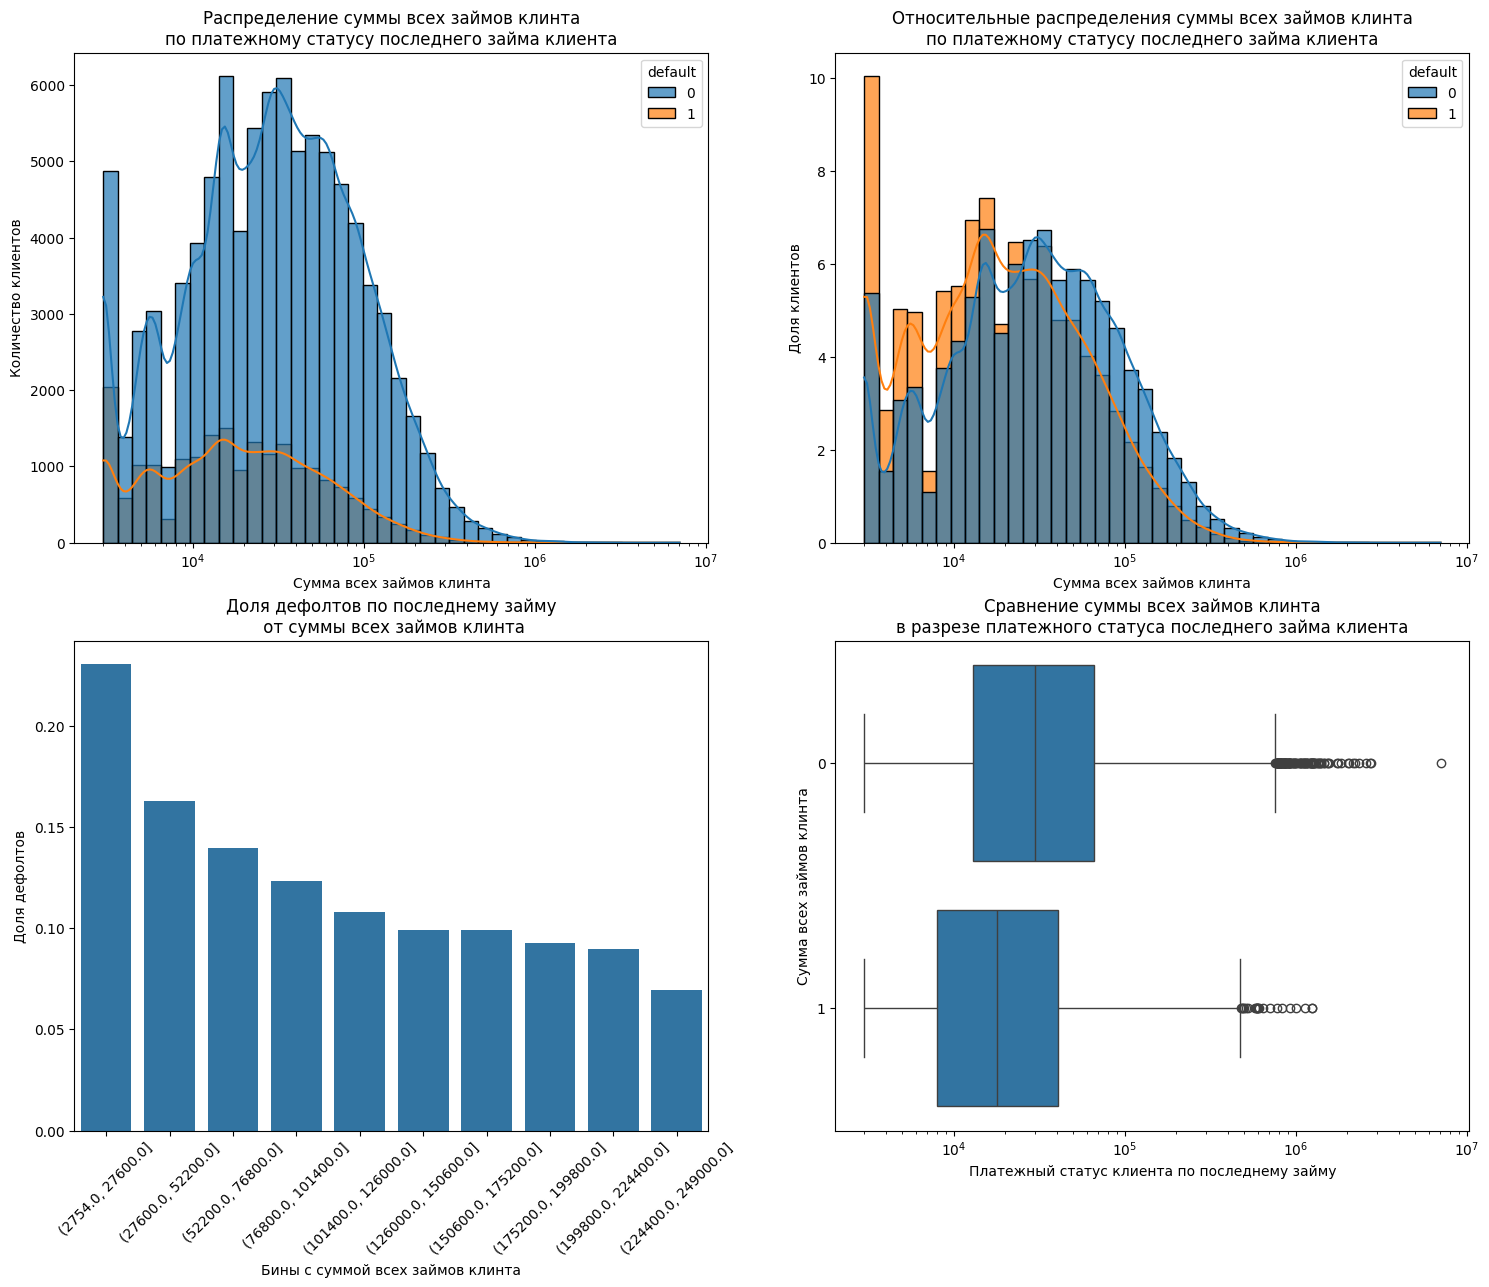

In [87]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Гистограмма
sns.histplot(data=model_data, x='total_loan_amount', hue='default', kde=True, ax=axes[0][0], alpha=0.7, bins=40, log_scale=True)
axes[0][0].set_title('Распределение суммы всех займов клинта' + '\n' + 'по платежному статусу последнего займа клиента')
axes[0][0].set_xlabel('Сумма всех займов клинта')  
axes[0][0].set_ylabel('Количество клиентов') 

# Гистограмма
sns.histplot(data=model_data, x='total_loan_amount', hue='default', kde=True, ax=axes[0][1], alpha=0.7, bins=40,stat='percent', common_norm=False, log_scale=True)
axes[0][1].set_title('Относительные распределения суммы всех займов клинта' + '\n' + 'по платежному статусу последнего займа клиента')
axes[0][1].set_xlabel('Сумма всех займов клинта')  
axes[0][1].set_ylabel('Доля клиентов')

# Боксплот
sns.boxplot(data=model_data, y='default', x='total_loan_amount', ax=axes[1][1],orient='h', log_scale=True)
axes[1][1].set_title('Сравнение суммы всех займов клинта' + '\n' + 'в разрезе платежного статуса последнего займа клиента')
axes[1][1].set_ylabel('Сумма всех займов клинта')  
axes[1][1].set_xlabel('Платежный статус клиента по последнему займу') 

model_data_copy = model_data.copy()
# Разобьем на 10 частей и посмотрим дефолты в них
model_data_copy['loan_bins'] = pd.cut(model_data[model_data['total_loan_amount']<250000]['total_loan_amount'], bins=10,precision=0)
default_rate = model_data_copy.groupby('loan_bins')['default'].mean()
sns.barplot(x=default_rate.index.astype(str), y=default_rate.values, ax=axes[1][0])
axes[1][0].set_title('Доля дефолтов по последнему займу' + '\n' + ' от суммы всех займов клинта')
axes[1][0].tick_params(axis='x', rotation=45)
axes[1][0].set_ylabel('Доля дефолтов')  
axes[1][0].set_xlabel('Бины с суммой всех займов клинта');

Общая визуализация хорошая, но чтоб посмотреть конкретные значения ограничимся размером долга в 150000.

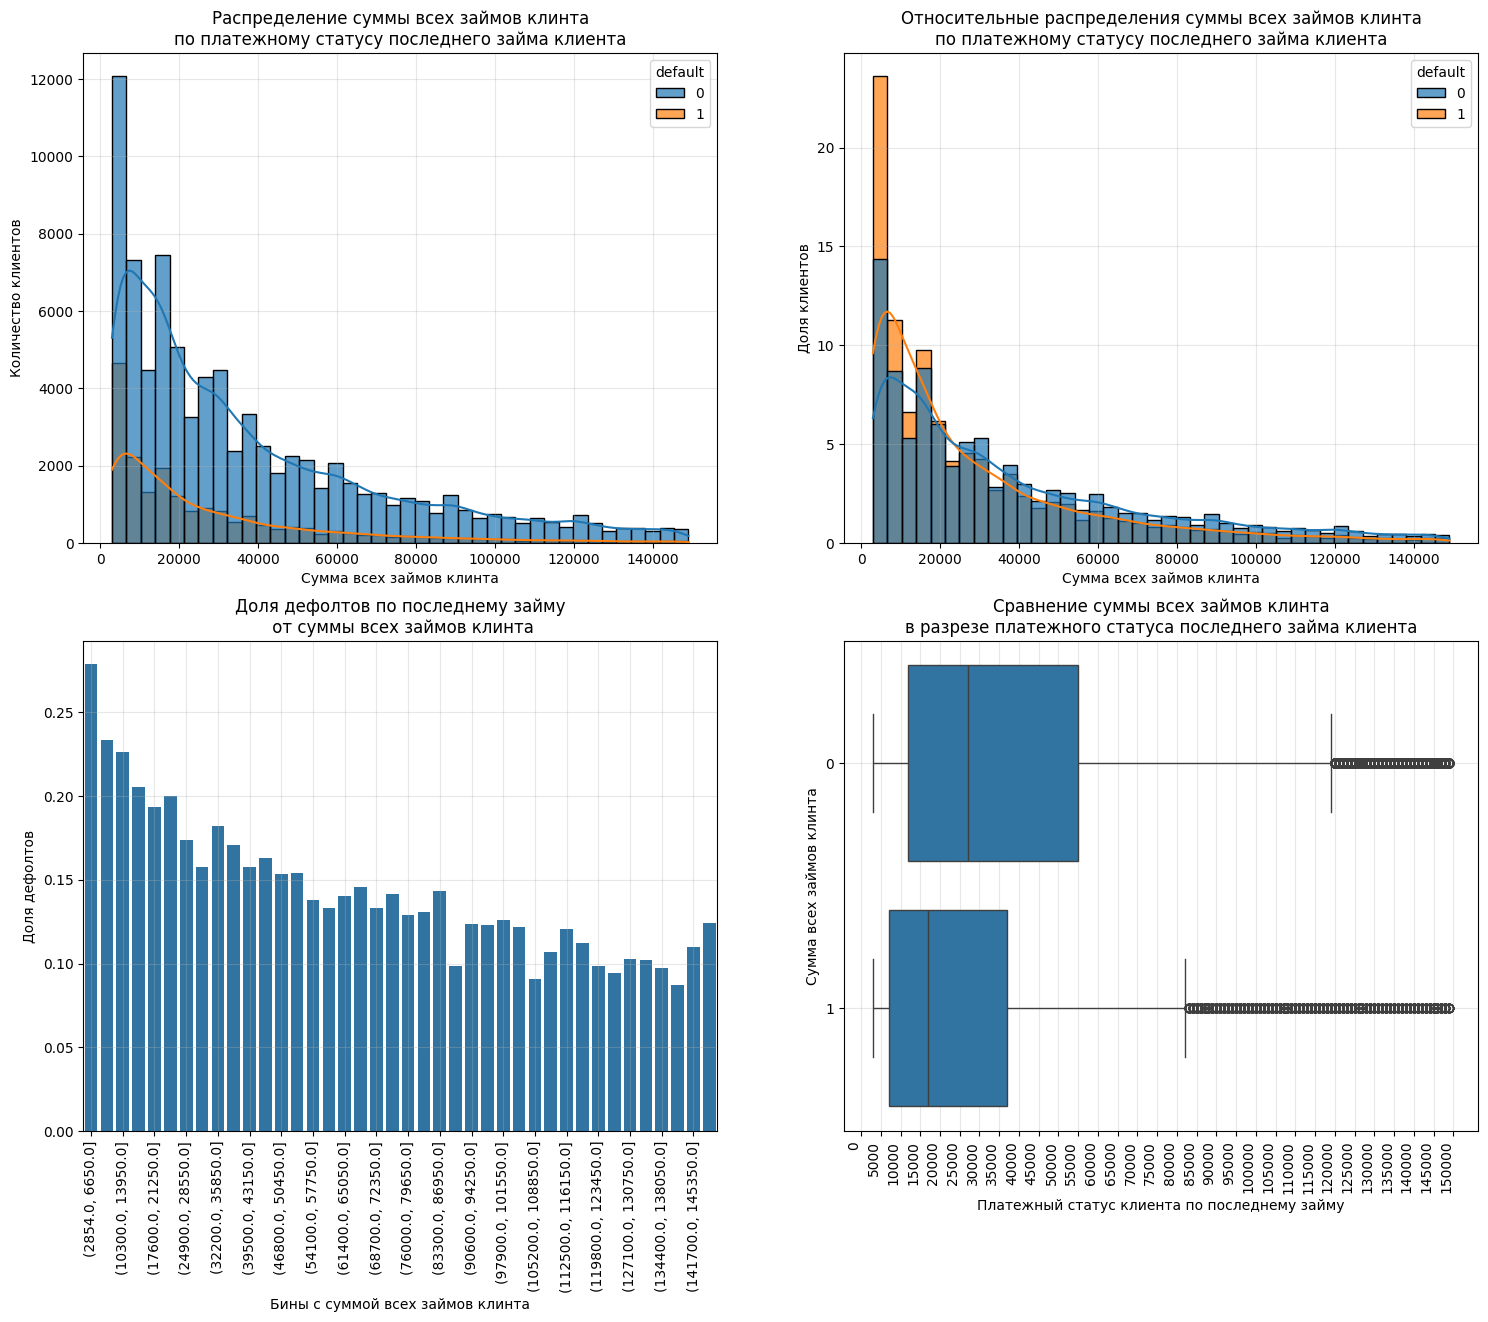

In [88]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Гистограмма
sns.histplot(data=model_data[model_data['total_loan_amount'] < 150000], x='total_loan_amount', hue='default', kde=True, ax=axes[0][0], alpha=0.7, bins=40)
#axes[0][0].set_xticks(np.arange(0, 81, 5)) 
#axes[0][0].set_yticks(np.arange(0, 8600, 500))
axes[0][0].grid(True, alpha=0.3)
axes[0][0].set_title('Распределение суммы всех займов клинта' + '\n' + 'по платежному статусу последнего займа клиента')
axes[0][0].set_xlabel('Сумма всех займов клинта')  
axes[0][0].set_ylabel('Количество клиентов')

# Гистограмма
sns.histplot(data=model_data[model_data['total_loan_amount'] < 150000], x='total_loan_amount', hue='default', kde=True, ax=axes[0][1], alpha=0.7, bins=40,stat='percent', common_norm=False)
axes[0][1].set_title('Относительные распределения суммы всех займов клинта' + '\n' + 'по платежному статусу последнего займа клиента')
axes[0][1].set_xlabel('Сумма всех займов клинта')  
axes[0][1].set_ylabel('Доля клиентов')  
#axes[0][1].set_xticks(np.arange(0, 81, 5))
#axes[0][1].set_yticks(np.arange(0, 11, 1))
axes[0][1].grid(True, alpha=0.3)

# Боксплот
sns.boxplot(data=model_data[model_data['total_loan_amount'] < 150000], y='default', x='total_loan_amount', ax=axes[1][1],orient='h')
axes[1][1].set_title('Сравнение суммы всех займов клинта' + '\n' + 'в разрезе платежного статуса последнего займа клиента')
axes[1][1].set_ylabel('Сумма всех займов клинта')  
axes[1][1].set_xlabel('Платежный статус клиента по последнему займу') 
axes[1][1].set_xticks(np.arange(0, 151000, 5000))
axes[1][1].set_xticklabels(np.arange(0, 151000, 5000), rotation=90, ha='right') 
axes[1][1].grid(True, alpha=0.3)


model_data_copy = model_data.copy()
# Разобьем на 10 частей и посмотрим дефолты в них
model_data_copy['loan_bins'] = pd.cut(model_data[model_data['total_loan_amount'] < 150000]['total_loan_amount'], bins=40,precision=0)
default_rate = model_data_copy.groupby('loan_bins')['default'].mean()
sns.barplot(x=default_rate.index.astype(str), y=default_rate.values, ax=axes[1][0])
axes[1][0].set_title('Доля дефолтов по последнему займу' + '\n' + ' от суммы всех займов клинта')
axes[1][0].tick_params(axis='x', rotation=90)
#axes[1][0].set_yticks(np.arange(0, 0.6, 0.05))
axes[1][0].grid(True, alpha=0.3)
ticks_positions = range(0, len(default_rate.index), 2)
ticks_labels = [str(default_rate.index[i]) for i in ticks_positions]
axes[1][0].set_xticks(ticks_positions)
axes[1][0].set_xticklabels(ticks_labels, rotation=90)
axes[1][0].set_ylabel('Доля дефолтов')  
axes[1][0].set_xlabel('Бины с суммой всех займов клинта');

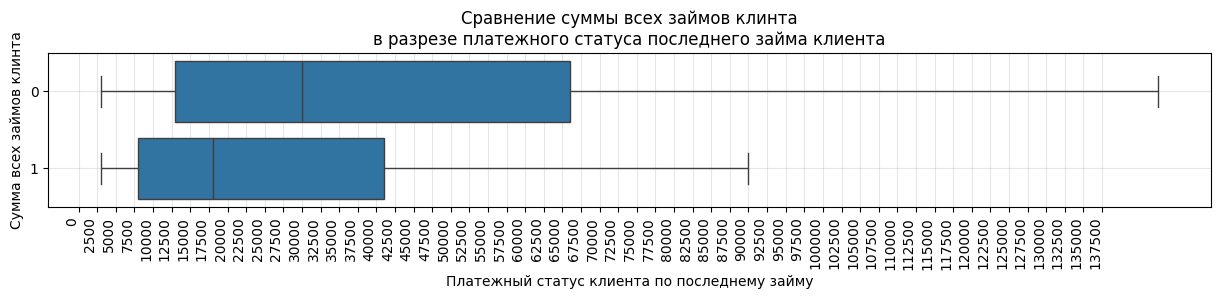

In [89]:
fig, axes = plt.subplots(1, 1, figsize=(15, 2))
# Боксплот
sns.boxplot(data=model_data, y='default', x='total_loan_amount', ax=axes,orient='h', showfliers=False)
axes.set_title('Сравнение суммы всех займов клинта' + '\n' + 'в разрезе платежного статуса последнего займа клиента')
axes.set_ylabel('Сумма всех займов клинта')  
axes.set_xlabel('Платежный статус клиента по последнему займу') 
axes.grid(True, alpha=0.3)
axes.set_xticks(np.arange(0, 140000, 2500));
axes.set_xticklabels(np.arange(0, 140000, 2500), rotation=90, ha='right');

На первых графиках на логарифмированной шкале хорощо видно что дефолты распределены левее недефолтных значений, то есть чем меньше клиент занимал денег в принципе в своей истории, тем больше дефолтов. Это видно и по 3му графику, доля дефолтов снижается при увеличении общей суммы займов.  Наверное это косвенно отражается на количестве предыдущих займов, т.е. если клиент новый или берет второй займ, нужно отнестись серьезней, чем к проверенному клиенту с историей займов.
По последнему боксплоту видим, что:  
Дефолтные: Q1=7500, Медиана=17500, Q3=41000 руб  
Недефолтные: Q1=12500, Медиана=30000, Q3=66000 руб  
Медианное значение общей суммы займов и вообзе всё из распределение смещено в сторону низких сумм. 
Вывод очевиден: чем больше общая сумма - тем вероятность дефолта меньше.
   

На основании этого и графика 3 сформируем такие границы для признака total_loan_amount:
* total_loan_amount >= 50000 - низкий риск,
* 25000 <= total_loan_amount < 50000 - средний,
* 15000 <= total_loan_amount < 25000 - высокий,
* total_loan_amount < 15000 - очень высокий.

## 2.3.4 Средняя доля погашения займа

Построим такие же визуализации.

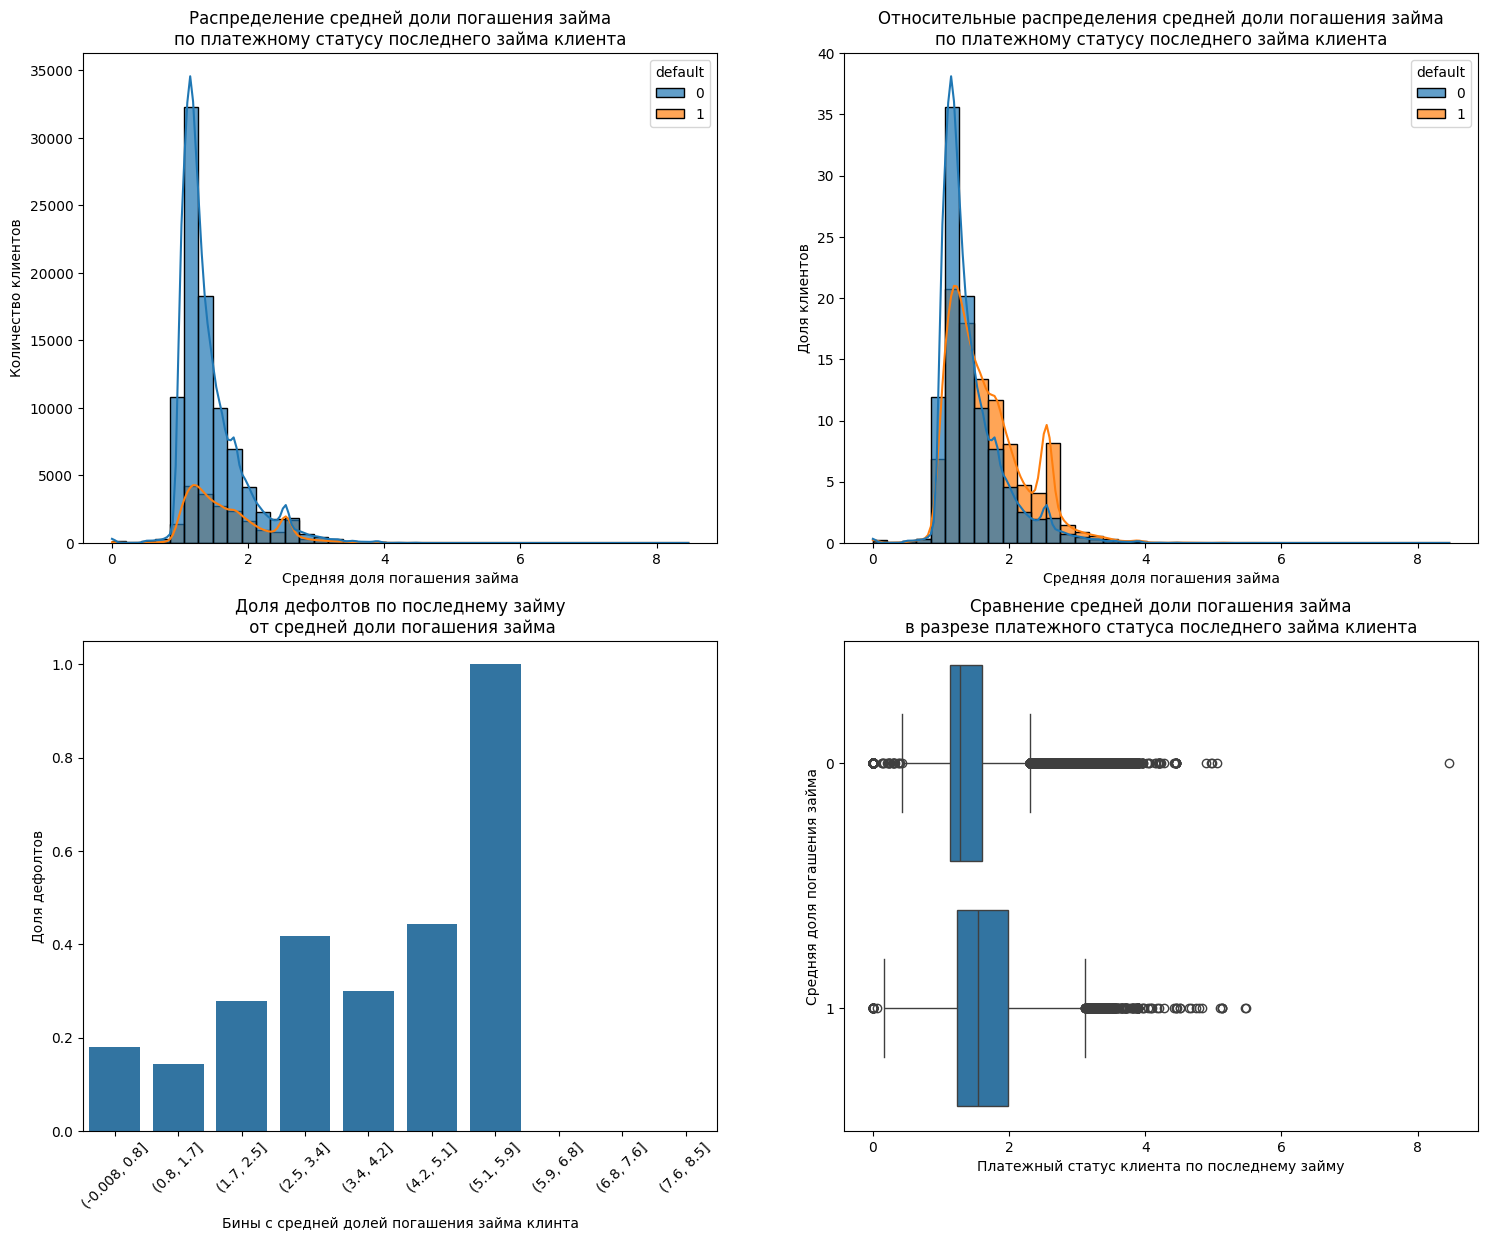

In [90]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Гистограмма
sns.histplot(data=model_data, x='avg_paid_ratio', hue='default', kde=True, ax=axes[0][0], alpha=0.7, bins=40, log_scale=False)
axes[0][0].set_title('Распределение средней доли погашения займа' + '\n' + 'по платежному статусу последнего займа клиента')
axes[0][0].set_xlabel('Средняя доля погашения займа')  
axes[0][0].set_ylabel('Количество клиентов')
#axes[0][0].set_xticks(np.arange(0, 8, 0.5)) 

# Гистограмма
sns.histplot(data=model_data, x='avg_paid_ratio', hue='default', kde=True, ax=axes[0][1], alpha=0.7, bins=40,stat='percent', common_norm=False, log_scale=False)
axes[0][1].set_title('Относительные распределения средней доли погашения займа' + '\n' + 'по платежному статусу последнего займа клиента')
axes[0][1].set_xlabel('Средняя доля погашения займа')  
axes[0][1].set_ylabel('Доля клиентов')
#axes[0][1].set_xticks(np.arange(0, 8, 0.5)) 

# Боксплот
sns.boxplot(data=model_data, y='default', x='avg_paid_ratio', ax=axes[1][1],orient='h', log_scale=False)
axes[1][1].set_title('Сравнение средней доли погашения займа' + '\n' + 'в разрезе платежного статуса последнего займа клиента')
axes[1][1].set_ylabel('Средняя доля погашения займа')  
axes[1][1].set_xlabel('Платежный статус клиента по последнему займу') 

model_data_copy = model_data.copy()
# Разобьем на 10 частей и посмотрим дефолты в них
model_data_copy['loan_bins'] = pd.cut(model_data['avg_paid_ratio'], bins=10,precision=0)
default_rate = model_data_copy.groupby('loan_bins')['default'].mean()
sns.barplot(x=default_rate.index.astype(str), y=default_rate.values, ax=axes[1][0])
axes[1][0].set_title('Доля дефолтов по последнему займу' + '\n' + ' от средней доли погашения займа')
axes[1][0].tick_params(axis='x', rotation=45)
axes[1][0].set_ylabel('Доля дефолтов')  
axes[1][0].set_xlabel('Бины с средней долей погашения займа клинта');

Средняя доля погашения займа - это отношение суммы всех платежей по займу к размеру займа для всех займов клиента. Это отношение может быть больше 1, т.к. клиент платит проценты, а не просто возвращает тело займа.   
Ограничим распределение отношением равным 4.

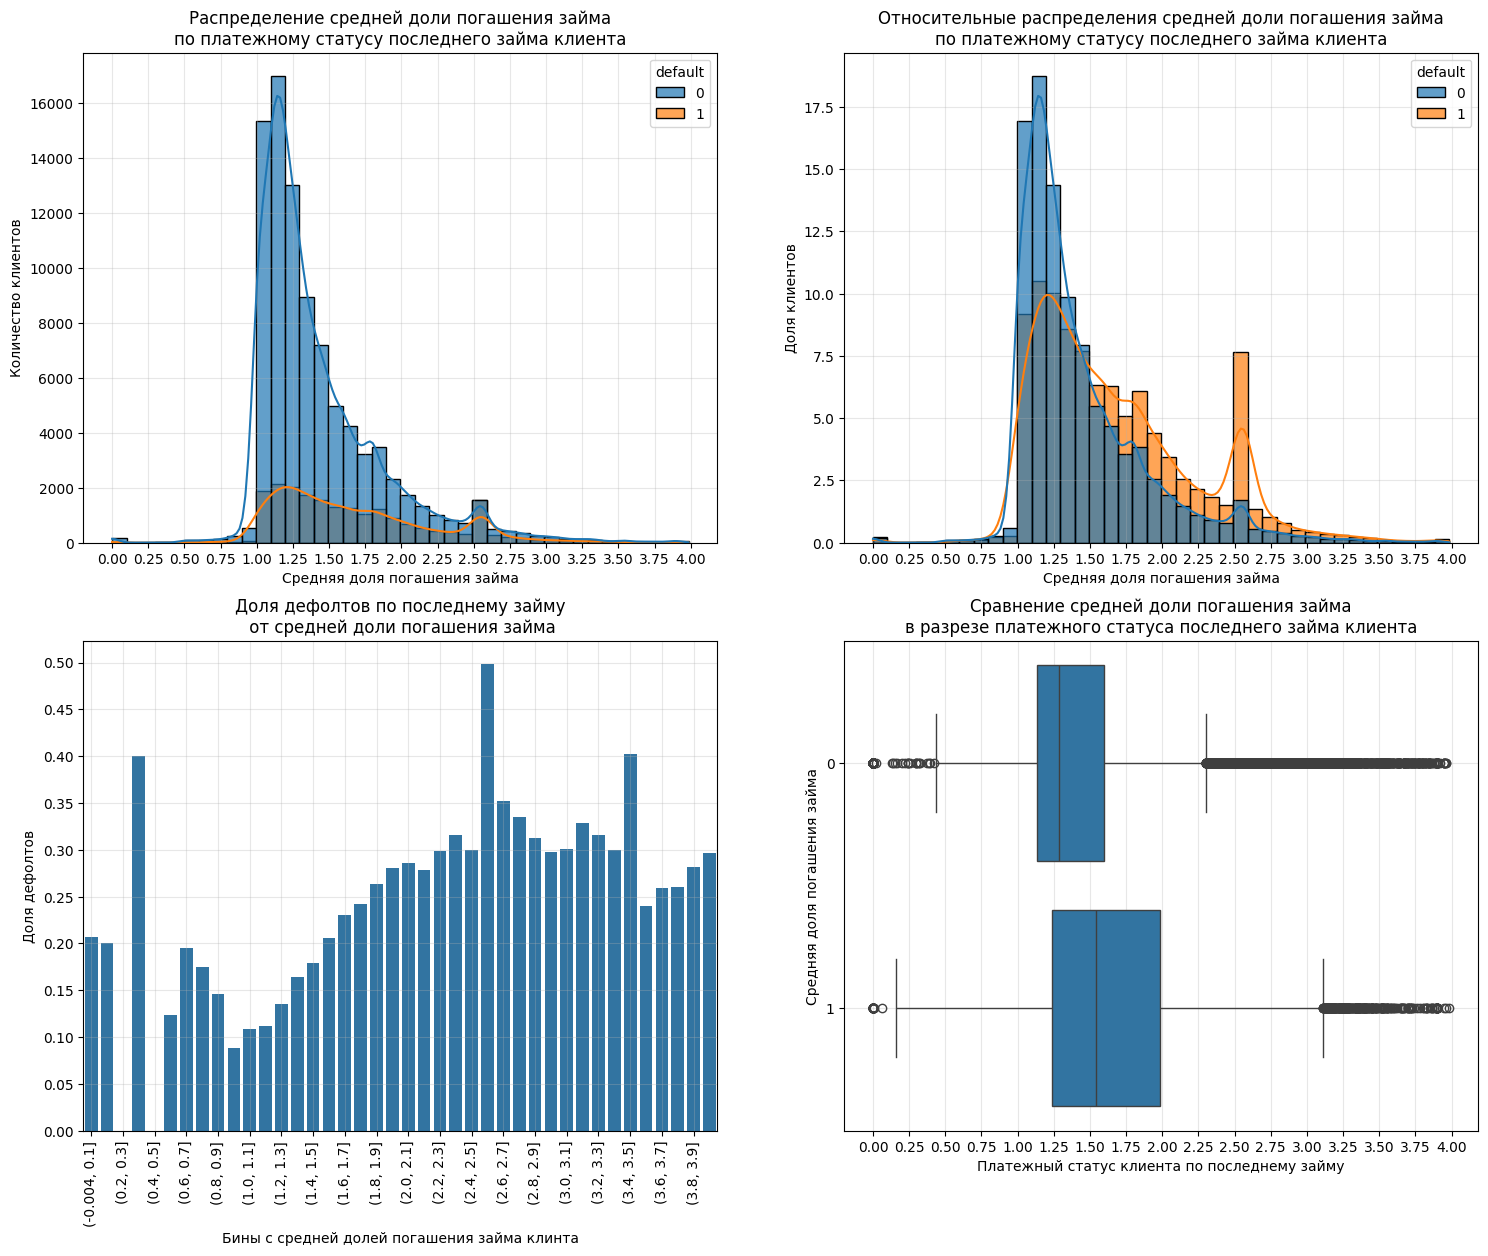

In [91]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Гистограмма
sns.histplot(data=model_data[model_data['avg_paid_ratio'] < 4], x='avg_paid_ratio', hue='default', kde=True, ax=axes[0][0], alpha=0.7, bins=40)
axes[0][0].set_xticks(np.arange(0, 4.1, 0.25)) 
#axes[0][0].set_yticks(np.arange(0, 8600, 500))
axes[0][0].grid(True, alpha=0.3)
axes[0][0].set_title('Распределение средней доли погашения займа' + '\n' + 'по платежному статусу последнего займа клиента')
axes[0][0].set_xlabel('Средняя доля погашения займа')  
axes[0][0].set_ylabel('Количество клиентов')

# Гистограмма
sns.histplot(data=model_data[model_data['avg_paid_ratio'] < 4], x='avg_paid_ratio', hue='default', kde=True, ax=axes[0][1], alpha=0.7, bins=40,stat='percent', common_norm=False)
axes[0][1].set_title('Относительные распределения средней доли погашения займа' + '\n' + 'по платежному статусу последнего займа клиента')
axes[0][1].set_xlabel('Средняя доля погашения займа')  
axes[0][1].set_ylabel('Доля клиентов')  
axes[0][1].set_xticks(np.arange(0, 4.1, 0.25)) 
#axes[0][1].set_yticks(np.arange(0, 11, 1))
axes[0][1].grid(True, alpha=0.3)

# Боксплот
sns.boxplot(data=model_data[model_data['avg_paid_ratio'] < 4], y='default', x='avg_paid_ratio', ax=axes[1][1],orient='h')
axes[1][1].set_title('Сравнение средней доли погашения займа' + '\n' + 'в разрезе платежного статуса последнего займа клиента')
axes[1][1].set_ylabel('Средняя доля погашения займа')  
axes[1][1].set_xlabel('Платежный статус клиента по последнему займу') 
axes[1][1].set_xticks(np.arange(0, 4.1, 0.25)) 
#axes[1][1].set_xticklabels(np.arange(0, 151000, 5000), rotation=90, ha='right') 
axes[1][1].grid(True, alpha=0.3)


model_data_copy = model_data.copy()
# Разобьем на 10 частей и посмотрим дефолты в них
model_data_copy['loan_bins'] = pd.cut(model_data[model_data['avg_paid_ratio'] < 4]['avg_paid_ratio'], bins=40,precision=0)
default_rate = model_data_copy.groupby('loan_bins')['default'].mean()
sns.barplot(x=default_rate.index.astype(str), y=default_rate.values, ax=axes[1][0])
axes[1][0].set_title('Доля дефолтов по последнему займу' + '\n' + ' от средней доли погашения займа')
axes[1][0].tick_params(axis='x', rotation=90)
axes[1][0].set_yticks(np.arange(0, 0.51, 0.05))
axes[1][0].grid(True, alpha=0.3)
ticks_positions = range(0, len(default_rate.index), 2)
ticks_labels = [str(default_rate.index[i]) for i in ticks_positions]
axes[1][0].set_xticks(ticks_positions)
axes[1][0].set_xticklabels(ticks_labels, rotation=90)
axes[1][0].set_ylabel('Доля дефолтов')  
axes[1][0].set_xlabel('Бины с средней долей погашения займа клинта');

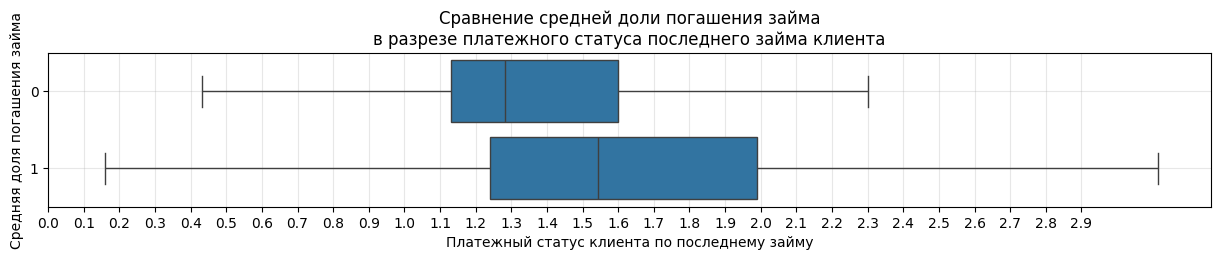

In [93]:
fig, axes = plt.subplots(1, 1, figsize=(15, 2))
# Боксплот
sns.boxplot(data=model_data, y='default', x='avg_paid_ratio', ax=axes,orient='h', showfliers=False)
axes.set_title('Сравнение средней доли погашения займа' + '\n' + 'в разрезе платежного статуса последнего займа клиента')
axes.set_ylabel('Средняя доля погашения займа')  
axes.set_xlabel('Платежный статус клиента по последнему займу') 
axes.grid(True, alpha=0.3)
axes.set_xticks(np.arange(0, 3, 0.1));

Видим, что распределение дефолтных клиентов смещено вправо относительно не дефолтных, то есть чем выще доля погашениямзайма - тем выше риск дефолта (что отлично видно на графике 3). Распределение имеет явный пик при доле погашения 2.5 - кол-во дефолтный и недефолтных клииетов тут равно (график 1),соответственно доля дефолтов равна 50% (график 3), 7.5% (на ограниченной выборке, но значение похоже на "полном" графике) от всех дефолтных клиентов имеют такую долю погашения (график 2).   
Распределение недефолтных клиентов влево подтверждается последним боксплотом.  
Дефолтные: Q1 = 1.25, Медиана = 1.55, Q3 = 2.0      
Недефолтные: Q1 = 1.1, Медиана = 1.28, Q3 = 1.6  

Но еще я бы разбил инретпритацию этого признака на <1 и >1, т.к. на графике 3 мы и видим минимум риска при 1. Взял займ - вернул ровно столько же, процентов не переплачивал, минимум риск дефолта, вопросов к товарищу не имеем.   
- При значении доли погашения займа >1 смысл такой, что чем больше клиент исторически платит процентов, тем больше вероятность дефолта. Возможно он платит долго и понемногу, у него нет средств быстро вернуть долг, соответственно и нет средств сделать первый платеж. Чем дальше от 1 - нем выще риск дефолта.   
- При значении меньше 1, как видно на графике 3, доля дефолтов также высока. Это логично, сумма внесенных средств меньше тела займа, т.е. клиент не вернул займ. Получается шанс дефолта по первому платежу высок. Чем ближе к 1 - тем риск дефолта мменьше, то есть он почти вернул. 



Если тут делить на зоны по степени риска, то:
* 1.0 <= avg_paid_ratio <= 1.25 - низкий,
* 1.25 < avg_paid_ratio <= 1.5 - средний,
* 1.5 < avg_paid_ratio <= 1.9 и 0.5 < avg_paid_ratio < 1 - высокий,
* avg_paid_ratio > 1.9 и avg_paid_ratio < 0.5 - очень высокий.

## 2.3.5 Максимальное время займа (разница между датой зактырия и открытия)

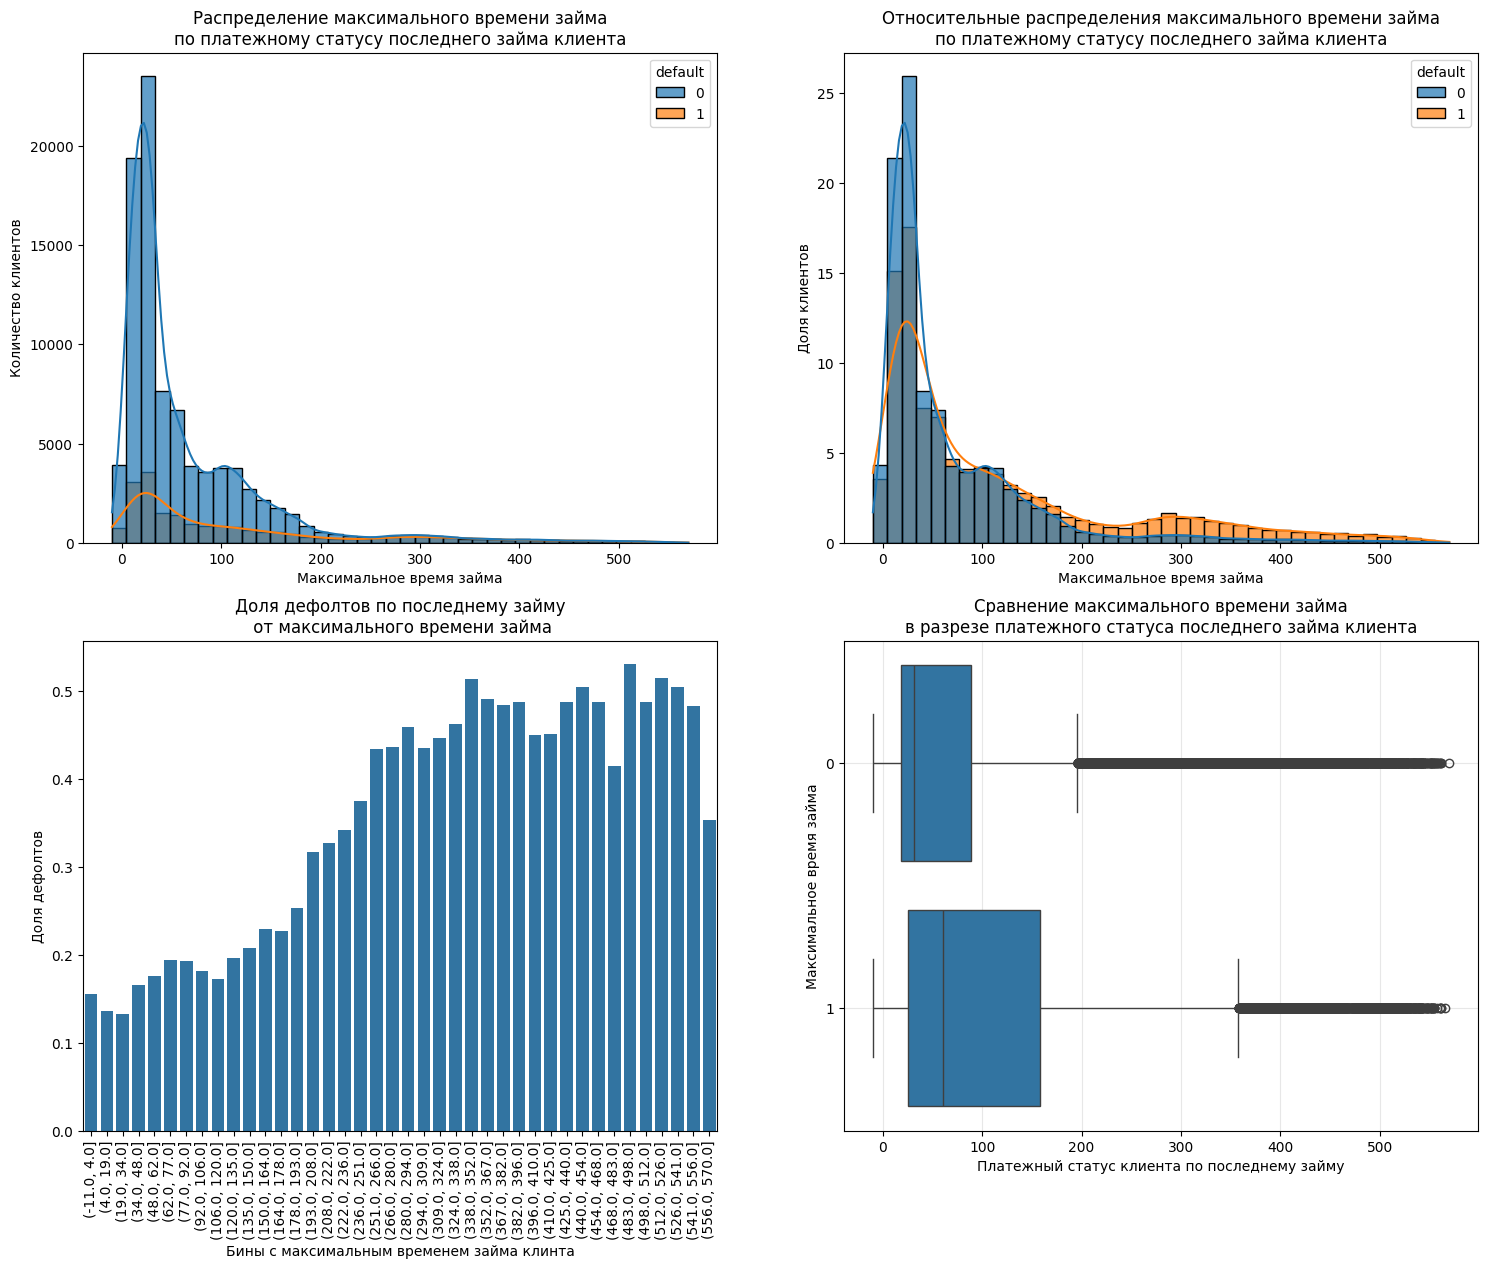

In [94]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Гистограмма
sns.histplot(data=model_data, x='max_loan_time', hue='default', kde=True, ax=axes[0][0], alpha=0.7, bins=40, log_scale=False)
axes[0][0].set_title('Распределение максимального времени займа' + '\n' + 'по платежному статусу последнего займа клиента')
axes[0][0].set_xlabel('Максимальное время займа')  
axes[0][0].set_ylabel('Количество клиентов')
#axes[0][0].set_xticks(np.arange(0, 8, 0.5)) 

# Гистограмма
sns.histplot(data=model_data, x='max_loan_time', hue='default', kde=True, ax=axes[0][1], alpha=0.7, bins=40,stat='percent', common_norm=False, log_scale=False)
axes[0][1].set_title('Относительные распределения максимального времени займа' + '\n' + 'по платежному статусу последнего займа клиента')
axes[0][1].set_xlabel('Максимальное время займа')  
axes[0][1].set_ylabel('Доля клиентов')
#axes[0][1].set_xticks(np.arange(0, 8, 0.5)) 

# Боксплот
sns.boxplot(data=model_data, y='default', x='max_loan_time', ax=axes[1][1],orient='h', log_scale=False, showfliers=True)
axes[1][1].set_title('Сравнение максимального времени займа' + '\n' + 'в разрезе платежного статуса последнего займа клиента')
axes[1][1].set_ylabel('Максимальное время займа')  
axes[1][1].set_xlabel('Платежный статус клиента по последнему займу') 
#axes[1][1].set_xticks(np.arange(0, 500, 10)) 
#axes[1][1].set_xticklabels(np.arange(0, 500, 10), rotation=90, ha='right') 
axes[1][1].grid(True, alpha=0.3)

model_data_copy = model_data.copy()
# Разобьем на 10 частей и посмотрим дефолты в них
model_data_copy['loan_bins'] = pd.cut(model_data['max_loan_time'], bins=40,precision=0)
default_rate = model_data_copy.groupby('loan_bins')['default'].mean()
sns.barplot(x=default_rate.index.astype(str), y=default_rate.values, ax=axes[1][0])
axes[1][0].set_title('Доля дефолтов по последнему займу' + '\n' + ' от максимального времени займа')
axes[1][0].tick_params(axis='x', rotation=90)
axes[1][0].set_ylabel('Доля дефолтов')  
axes[1][0].set_xlabel('Бины с максимальным временем займа клинта');

Тут тоже картина логична. Логарифмированную шкалу применить не можем (много клиентов с датой займов в 0 дней + у кого нет займов мы присваивали значение -10, но таких мало), ограничимся сроком в 200 дней.

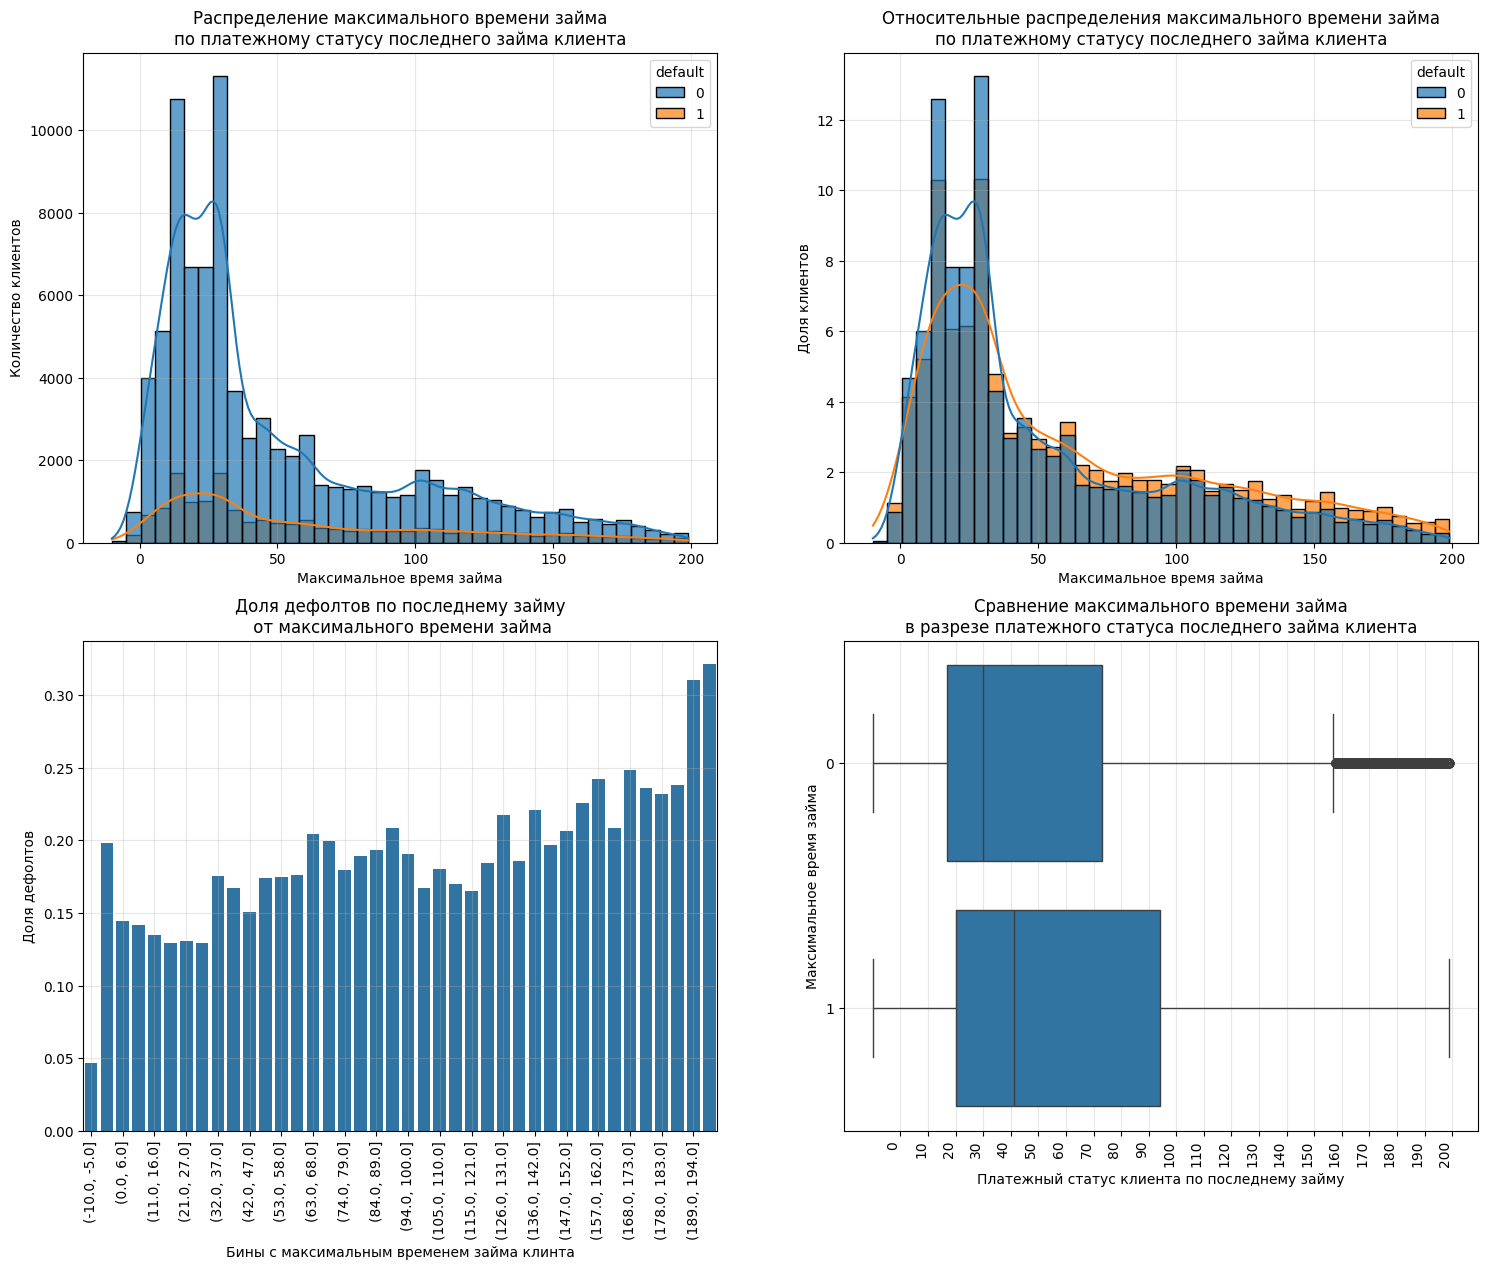

In [95]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Гистограмма
sns.histplot(data=model_data[model_data['max_loan_time'] < 200], x='max_loan_time', hue='default', kde=True, ax=axes[0][0], alpha=0.7, bins=40)
#axes[0][0].set_xticks(np.arange(0, 4.1, 0.25)) 
#axes[0][0].set_yticks(np.arange(0, 8600, 500))
axes[0][0].grid(True, alpha=0.3)
axes[0][0].set_title('Распределение максимального времени займа' + '\n' + 'по платежному статусу последнего займа клиента')
axes[0][0].set_xlabel('Максимальное время займа')   
axes[0][0].set_ylabel('Количество клиентов')

# Гистограмма
sns.histplot(data=model_data[model_data['max_loan_time'] < 200], x='max_loan_time', hue='default', kde=True, ax=axes[0][1], alpha=0.7, bins=40,stat='percent', common_norm=False)
axes[0][1].set_title('Относительные распределения максимального времени займа' + '\n' + 'по платежному статусу последнего займа клиента')
axes[0][1].set_xlabel('Максимальное время займа')  
axes[0][1].set_ylabel('Доля клиентов')  
#axes[0][1].set_xticks(np.arange(0, 4.1, 0.25)) 
#axes[0][1].set_yticks(np.arange(0, 11, 1))
axes[0][1].grid(True, alpha=0.3)

# Боксплот
sns.boxplot(data=model_data[model_data['max_loan_time'] < 200], y='default', x='max_loan_time', ax=axes[1][1],orient='h')
axes[1][1].set_title('Сравнение максимального времени займа' + '\n' + 'в разрезе платежного статуса последнего займа клиента')
axes[1][1].set_ylabel('Максимальное время займа')  
axes[1][1].set_xlabel('Платежный статус клиента по последнему займу') 
axes[1][1].set_xticks(np.arange(0, 210, 10)) 
axes[1][1].set_xticklabels(np.arange(0, 210, 10), rotation=90, ha='right') 
axes[1][1].grid(True, alpha=0.3)


model_data_copy = model_data.copy()
# Разобьем на 10 частей и посмотрим дефолты в них
model_data_copy['loan_bins'] = pd.cut(model_data[model_data['max_loan_time'] < 200]['max_loan_time'], bins=40,precision=0)
default_rate = model_data_copy.groupby('loan_bins')['default'].mean()
sns.barplot(x=default_rate.index.astype(str), y=default_rate.values, ax=axes[1][0])
axes[1][0].set_title('Доля дефолтов по последнему займу' + '\n' + ' от максимального времени займа')
axes[1][0].tick_params(axis='x', rotation=90)
#axes[1][0].set_yticks(np.arange(0, 0.51, 0.05))
axes[1][0].grid(True, alpha=0.3)
ticks_positions = range(0, len(default_rate.index), 2)
ticks_labels = [str(default_rate.index[i]) for i in ticks_positions]
axes[1][0].set_xticks(ticks_positions)
axes[1][0].set_xticklabels(ticks_labels, rotation=90)
axes[1][0].set_ylabel('Доля дефолтов')  
axes[1][0].set_xlabel('Бины с максимальным временем займа клинта');

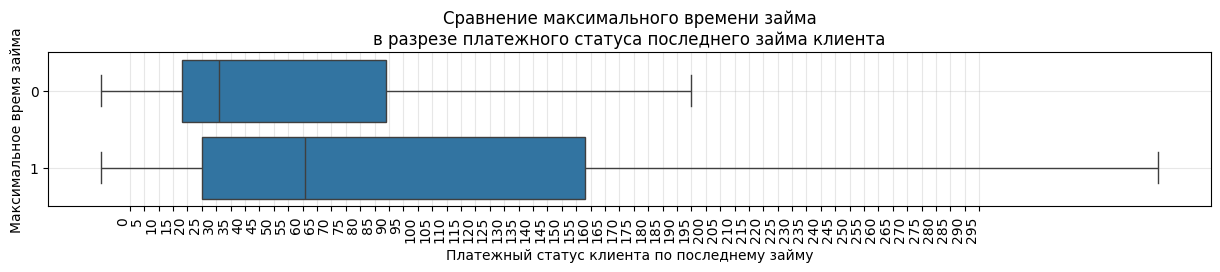

In [96]:
fig, axes = plt.subplots(1, 1, figsize=(15, 2))
# Боксплот
sns.boxplot(data=model_data, y='default', x='max_loan_time', ax=axes,orient='h', showfliers=False)
axes.set_title('Сравнение максимального времени займа' + '\n' + 'в разрезе платежного статуса последнего займа клиента')
axes.set_ylabel('Максимальное время займа')  
axes.set_xlabel('Платежный статус клиента по последнему займу') 
axes.grid(True, alpha=0.3)
axes.set_xticks(np.arange(0, 300, 5));
axes.set_xticklabels(np.arange(0, 300, 5), rotation=90, ha='right');

По графикам може увидить, что распределение дефолтных клиентов по максимальному времени займа смещено правее. Этот признак на мой взгяд имеет корреляцию с предыдущим - чем дольше займ, тем труднее заемщику его возвращать, иначе он бы вернул побыстрее. и возможно труднее вернуть первый платеж.
Дефолтные: Q1 = 25, Медиана = 60, Q3 = 160      
Недефолтные: Q1 = 18, Медиана = 31, Q3 = 90.
Видим, что 50% недефолтных по последнему займу клиентов историчеки закрывают заем в течение 31 дня. А вот половина дефолтных клиентов закрывает заем в течение 60 дней, а 75% делают это аж до 160 дней, огромная разница с недефолтным значением Q3 в 90 дней.

Итак:
* max_loan_time <= 30 - низкий,
* 30 < max_loan_time <= 60 - средний,
* 60 < max_loan_time <= 90 - высокий,
* max_loan_time > 90 - очень высокий.

# **Часть 3**
#### Используя предсказания выбранной модели, предложить алгоритм формирования суммы выдачи для клиентов из обучающей выборки. Дополнительно, вместе с предсказанием выбранной модели, можно использовать сгенерированные признаки для формирования суммы выдачи.

Я проанализировал 5 ключевых признаков и для каждого составил ранжирование по уровню риска. Теперь нужно получить некий коэффициент риска клиента по этим признакам.  
Также мы имеем модель, которая предсказывает вероятность дефолта. Нужно использовать эту информацию и определить некий коэффициент риска клиента на основании предсказания модели.  
Потом на основании этих коэффициентов определим риск-профиль клиента (как обобщающий коэффициент) и учитывая его и ту сумму, которую запрашивает клиент посчитаем одобренную к выдаче сумму.   
Т.к. нам нужно это сделать это для каждого клиента, нужно сделать это в виде функции, чтоб применить ко всей обучающей выборке.

В общем:
1. Сделать функцию, которая определяет коэффициент риска дефолта клиента на основании анализа ключевых признаков
2. Сделать функцию, которая определяет коэффициент риска дефолта клиента на основании предсказания модели
3. Сделать функцию, которая на основании результатов предыдущих функий определет размер выдаваемого займа.

## 3.1 Определяем уровень риска на основании анализа ключевых признаков

У нас уже есть анализ клиента по 5 ключевым признакам и готовые группы по уровню риска для каждого признака. Нужно просто обернуть это в код и в функцию, чтоб потом применить к каждому клиенту в обучающей выборке. Будем присваивать риск-баллы 0т 1 до 4 по каждому признаку. Чем больше риск - тем больше баллов. В конце полученную сумму риск-баллов переведем в коэффициент риска от 0 до 1, чтоб умножать на него сумму запрашиваемого займа.
Это будет один из двух коэффициентов риска - коэффициентов риска на основании признаков risk_koef_feature.



In [97]:
def risk_koef_features(client):
    """
    Функция принимает на вход строку таблицы, в соответствии со значением каждого ключевого признака считает риск-баллы и в конце переводит это в коэффициент риска на основании признаков и возвращает его
    """
    risk_score = 0
    
    # 1. Среднее количество дней до первого платежа
    avg_days = client['avg_days_to_first_payment']
    if avg_days <= 11:
        risk_score += 1
    elif avg_days <= 16:
        risk_score += 2
    elif avg_days <= 23:
        risk_score += 3
    else:
        risk_score += 4
    
    # 2. Запрашиваемая сумма
    loan_start = client['loan_amount_start']
    if loan_start <= 5000:
        risk_score += 1
    elif loan_start <= 16000:
        risk_score += 2
    elif loan_start <= 22000:
        risk_score += 3
    else:
        risk_score += 4
    
    # 3. Общая сумма всех займов
    total_loans = client['total_loan_amount']
    if total_loans >= 50000:
        risk_score += 1
    elif total_loans >= 25000:
        risk_score += 2
    elif total_loans >= 15000:
        risk_score += 3
    else:
        risk_score += 4
    
    # 4. Средняя доля погашения займа
    paid_ratio = client['avg_paid_ratio']
    if 1.0 <= paid_ratio <= 1.25:
        risk_score += 1
    elif 1.25 < paid_ratio <= 1.5:
        risk_score += 2
    elif (1.5 < paid_ratio <= 1.9) or (0.5 < paid_ratio < 1.0):
        risk_score += 3
    else:
        risk_score += 4
    
    # 5. Максимальное время займа
    max_time = client['max_loan_time']
    if max_time <= 30:
        risk_score += 1
    elif max_time <= 60:
        risk_score += 2
    elif max_time <= 90:
        risk_score += 3
    else:
        risk_score += 4
   
    # Tеперь эти баллы нужно перевести в значение меньше 1, чтоб умножать на это число максимальную сумму займа. У нас чем меньше баллов - тем надежнее товарищ
    
    if risk_score <= 8:
        risk_koef_feature = 1.0    # Низкий риск
    elif risk_score <= 12:
        risk_koef_feature = 0.9    # Средний
    elif risk_score <= 16:
        risk_koef_feature = 0.7    # Высокий
    else:
        risk_koef_feature = 0.5    # ОЧень высокий
        
    return risk_koef_feature

## 3.2 Определяем уровень риска на основании предсказания модели

Второй коэффициент риска - коэффициентов риска на основании предсказания модели. Соответственно также сделаем функцию, она на основании предсказания вероятности отношения клиента к классу 1  присвоит клиенту коэффициент риска по предсказанию модели risk_koef_model.

In [98]:
# сначала исходную таблицу отмасштабируем также, как и училась модель
model_data_scaled = scaler.transform(model_data.drop(columns='default', axis=1))
# создадим копию таблицы, чтоб в к ней добавлять риск-профиль
model_data_risk = model_data.copy()
# в ней создадим столбец предсказания вероятности отношения клиента к классу 1
model_data_risk['default_prob'] = gbc.predict_proba(model_data_scaled)[:, 1]

def risk_koef_models(client):
    """
    Функция принимает на вход строку таблицы и на основании вероятности отношения клиента к классу дефолт возвращает коэффициент риска
    """
    default_prob = client['default_prob']
    
    if default_prob < 0.2:
        risk_koef_model = 1.0  # Низкий риск
    elif default_prob < 0.4:
        risk_koef_model = 0.8  # Средний риск
    elif default_prob < 0.6:
        risk_koef_model = 0.6  # Высокий риск
    else:
        risk_koef_model = 0.4  # Очень высокий
    
    return risk_koef_model

## 3.3 Определяем размер выдаваемого займа

Теперь напишем функцию, которая определит размер одобренной суммы. 
Два коэффициента риска есть, на оновании них определим риск-профиль (можно как среднеарифметическое, можно одному коэффициенту задавать больший вес, можно умножать на них поочередно, т.е. функция позволит гибко настраивать этот момент).
Запрашиваемую клиентом сумму умножим на коэф. риск-профиль, проверяем чтоб сумма удовлетворяла условию задачи и возвращаем ее.

In [99]:
def approved_amount(client):
    """
    Функция принимает на вход строку таблицы, считает риск-профиль, на его основании рассчитывает одобренную сумму, проверяет на допустимые лимиты и возвращает эту сумму 
    """
    # Получаем коэффициенты риска, которые сделали ранее
    koef_feature = client['risk_koef_feature']
    koef_model = client['risk_koef_model']
    
    # Считаем риск-профиль
    # Здесь используем среднее арифметическое (можем поочередно умножать на них, тогда большая "перестраховка" получится)
    sum_risk_koef = (koef_feature + koef_model) / 2
    
    # Получаем запрашиваемую сумму
    loan_amount_start = client['loan_amount_start']
    
    # Рассчитываем одобренную сумму
    approved_amount = loan_amount_start * sum_risk_koef
    
    # Применим ограничения по условиям задачи
    if approved_amount > 30000:
        approved_amount = 30000
    if approved_amount < 3000:
        approved_amount = 3000
      
    return approved_amount

## 3.4 Применяем функции к обучающей выборке

In [100]:
model_data_risk['risk_koef_feature'] = model_data_risk.apply(risk_koef_features, axis=1)
model_data_risk['risk_koef_model'] = model_data_risk.apply(risk_koef_models, axis=1)
model_data_risk['approved_amount'] = model_data_risk.apply(approved_amount, axis=1)

In [101]:
model_data_risk

,client_id,default,prev_loans_count,avg_loan_amount,total_loan_amount,avg_loan_period,default_rate_history,avg_payment_count,avg_paid_ratio,avg_pay_type_ratio,avg_days_to_first_payment,avg_payment_period_days,max_loan_time,loan_amount_start,loan_amount,loan_period,default_prob,risk_koef_feature,risk_koef_model,approved_amount
0,18499732,1,2,7500.0,15000.0,30.0,0.0,1.0,1.224400,0.00,20.0,0.00,30.0,20000,17000.0,30,0.523466,0.9,0.6,15000.0
1,18499750,1,2,6500.0,13000.0,23.0,0.0,1.0,1.448000,0.00,13.0,0.00,14.0,10000,10000.0,30,0.572609,0.9,0.6,7500.0
2,18500194,1,5,8800.0,44000.0,30.0,0.0,1.0,1.392400,0.00,23.6,0.00,30.0,30000,18000.0,30,0.526257,0.7,0.6,19500.0
3,18500323,0,4,19000.0,76000.0,30.0,0.0,3.0,1.543184,0.45,29.5,21.75,64.0,30000,30000.0,30,0.208620,0.7,0.8,22500.0
4,18500393,0,1,10000.0,10000.0,30.0,0.0,1.0,1.520000,0.00,28.0,0.00,28.0,5000,5000.0,16,0.186610,0.7,1.0,4250.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111026,55478285,0,2,8000.0,16000.0,30.0,0.0,1.0,0.649750,0.00,14.5,0.00,0.0,20000,8000.0,30,0.385395,0.9,0.8,17000.0
111027,55478919,0,1,3000.0,3000.0,30.0,0.0,1.0,1.800000,0.00,0.0,0.00,0.0,30000,3000.0,30,0.732589,0.7,0.4,16500.0
111028,55481323,0,1,3000.0,3000.0,30.0,0.0,1.0,1.072000,0.00,9.0,0.00,9.0,4000,4000.0,16,0.139008,1.0,1.0,4000.0
111029,55491429,0,1,3000.0,3000.0,30.0,0.0,1.0,1.000000,0.00,0.0,0.00,0.0,15000,3000.0,30,0.496056,0.9,0.6,11250.0


Ура, задание выполнено, алгоритм формирования суммы выдачи для клиентов на основании предсказания модели и сгенерированных признаков работает, одобренная сумма находится в столбце approved_amount.